In [107]:
import gurobipy as gp
import os
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter, PercentFormatter
import numpy as np
import pandas as pd
import re
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import shutil

In [108]:
# get input paths
test_set = "miplib_2017_5000"
instance_fldr = os.path.join("instances", test_set)
test_set_fldr = os.path.join("test_sets", test_set)
results_fldr = os.path.join("results", test_set)
out_fldr = os.path.join("outputs", test_set)

# set filters
degrees = [-1, 1]
term_list = [4, 16, 64]
filter_cbc = False
max_base_std = 1e10
min_termination_time = 1
remove_status_changes = False
remove_matrix_perturbations = False

## Check run failures

In [109]:
# check if each folder in test_set_fldr has a corresponding .mps file in instance_fldr
# for instance in os.listdir(test_set_fldr):
#     if not os.path.isdir(os.path.join(test_set_fldr, instance)):
#         continue
#     if not os.path.exists(os.path.join(instance_fldr, f"{instance}.mps")):
#         # remove the folder if the instance is missing
#         # shutil.rmtree(os.path.join(test_set_fldr, instance))
#         print(f"Removed {instance} from test set")

In [110]:
# running list of strings contained by different error codes
# last two are catchalls
err = {
    "walltime": [],
    "bad_alloc": [],
    "out of memory": [],
    "takeoffcuts": [],
    "solver is dual infeasible": [],
    "solver must be optimal": [],
    "segmentation fault": [],
    "no vpcs were made from a new disjunction": [],
    "must have primalbound >= root lp objective": [],
    "objective at parent node": [],
    "failed to optimize mip": [],
    "disjunction does not represent a full binary tree": [],
    "solver not proven optimal for node": [],
    "unable to open": [],
    "license": [],
    "dot product with obj differs from solver": [],
    "gurobi: error during callback: addCut": [],
    "cglvpc::setupconstraints: objective at disjunctive term": [],
    "unable to read file": [],
    "stats.id == stats_vec": [],
    "size of our disjunction is not what we expected it to be": [],
}

# read in cbc acceptable instances from cbc.txt
with open("cbc.txt", "r") as f:
    cbc_instances = f.read().split("\n")

# runs that errored out with new error code
other = []

# runs that had no errors
empty = []

# runs that only had warnings
warn_strs = ["warning", "prlp is primal infeasible", "farkas", "x:", "x[", "b:",
             "b[", "v:", "v[", "cut:", "A_i . x", "dot product with obj differs from solver"]
warning = []

# series that didn't run
no_go = []

# track sizes of instances
rows, cols, density = {}, {}, {}

# map the names
names = {}

# counts
count_series = 0
count_instances = 0
number_instances = {}

# iterate over all expected runs
for instance in os.listdir(test_set_fldr):
    if not os.path.isdir(os.path.join(test_set_fldr, instance)):
        continue
    # only look at cbc instances if we ran with cbc
    if instance not in cbc_instances and "gurobi" not in test_set and filter_cbc:
        continue
        
    # get the number of rows and columns in the instance
    mdl = gp.read(os.path.join(instance_fldr, f"{instance}.mps"))
    rows[instance] = mdl.NumConstrs
    cols[instance] = mdl.NumVars
    density[instance] = mdl.NumNZs / (mdl.NumConstrs * mdl.NumVars)
        
    for perturbation in os.listdir(os.path.join(test_set_fldr, instance)):
        if not os.path.isdir(os.path.join(test_set_fldr, instance, perturbation)):
            continue
        # only look at perturbations that were run
        p, d = perturbation.split("_")
        if int(d) not in degrees:
            continue
        for terms in term_list:
            for generator in ["None", "New", "Old", "Farkas"]:

                # set variables for this iteration
                count_series += 1
                stem = f"{instance}_{perturbation}_{terms}_{generator}"
                file_pth = os.path.join(results_fldr, f"{stem}.err")
                series_fldr = os.path.join(test_set_fldr, instance, perturbation)
                current_count = len([f for f in os.listdir(series_fldr) if f.endswith(".mps")])
                count_instances += current_count
                names[stem] = instance
                number_instances[stem] = {
                    "expected": current_count,
                    "recorded": 0,
                    "generator": generator,
                    "error": "N/A"
                }

                # check if the series wasn't run
                if not os.path.exists(file_pth):
                    number_instances[stem]["error"] = "no go"
                    no_go.append(stem)
                
                # check if the series ran with no errors or warnings
                elif os.path.getsize(file_pth) == 0:
                    number_instances[stem]["error"] = "empty"
                    empty.append(stem)
                
                # track which error codes were thrown
                else:
                    # read the file
                    with open(file_pth, "r") as f:
                        text = f.read().lower()
                    
                    # assign the error file to the appropriate list
                    found_code = False
                    for code in err:
                        if code in text:
                            if code == "dot product with obj differs from solver":
                                pattern = r"obj viol from solver: (\d+\.\d+)\. calculated: (\d+\.\d+)"
                                s, c = re.findall(pattern, text)[-1]
                                # if we didn't terminate, this isn't an error, so keep going
                                if abs(float(s) - float(c)) < 1e-3:
                                    continue
                            err[code].append(stem)
                            found_code = True
                            number_instances[stem]["error"] = code
                            break
                    if not found_code:
                        if all(not line or any(w in line for w in warn_strs) for line in text.splitlines()):
                            warning.append(stem)
                            number_instances[stem]["error"] = "warning"
                        else:
                            other.append(stem)
                            number_instances[stem]["error"] = "other"

Read MPS format model from file instances/miplib_2017_5000/bienst2.mps
Reading time = 0.01 seconds
bienst2: 576 rows, 505 columns, 2184 nonzeros
Read MPS format model from file instances/miplib_2017_5000/set3-15.mps
Reading time = 0.00 seconds
set3-15: 3747 rows, 4019 columns, 13747 nonzeros
Read MPS format model from file instances/miplib_2017_5000/f2gap801600.mps
Reading time = 0.00 seconds
f2gap801600: 80 rows, 1600 columns, 3200 nonzeros
Read MPS format model from file instances/miplib_2017_5000/stein15inf.mps
Reading time = 0.00 seconds
stein15inf: 37 rows, 15 columns, 135 nonzeros
Read MPS format model from file instances/miplib_2017_5000/neos-3610173-itata.mps
Reading time = 0.00 seconds
neos-3610173-itata: 747 rows, 844 columns, 2130 nonzeros
Read MPS format model from file instances/miplib_2017_5000/10teams.mps
Reading time = 0.00 seconds
10TEAMS: 230 rows, 2025 columns, 12150 nonzeros
Read MPS format model from file instances/miplib_2017_5000/gmu-35-40.mps
Reading time = 0.00

In [111]:
# check which series didn't run
print(no_go)

['mine-90-10_matrix_-1_4_None', 'mine-90-10_matrix_-1_4_New', 'mine-90-10_matrix_-1_4_Old', 'mine-90-10_matrix_-1_4_Farkas', 'mine-90-10_matrix_-1_16_None', 'mine-90-10_matrix_-1_16_New', 'mine-90-10_matrix_-1_16_Old', 'mine-90-10_matrix_-1_16_Farkas', 'mine-90-10_matrix_-1_64_None', 'mine-90-10_matrix_-1_64_New', 'mine-90-10_matrix_-1_64_Old', 'mine-90-10_matrix_-1_64_Farkas', 'mine-90-10_objective_-1_16_Farkas', 'mine-90-10_objective_-1_64_None', 'mine-90-10_objective_-1_64_New', 'mine-90-10_objective_-1_64_Old', 'mine-90-10_objective_-1_64_Farkas', 'a2c1s1_rhs_1_4_None', 'a2c1s1_rhs_1_4_New', 'a2c1s1_rhs_1_4_Old', 'a2c1s1_rhs_1_4_Farkas', 'a2c1s1_rhs_1_16_None', 'a2c1s1_rhs_1_16_New', 'a2c1s1_rhs_1_16_Old', 'a2c1s1_rhs_1_16_Farkas', 'a2c1s1_rhs_1_64_None', 'a2c1s1_rhs_1_64_New', 'a2c1s1_rhs_1_64_Old', 'a2c1s1_rhs_1_64_Farkas', 'a2c1s1_objective_1_4_None', 'a2c1s1_objective_1_4_New', 'a2c1s1_objective_1_4_Old', 'a2c1s1_objective_1_4_Farkas', 'a2c1s1_objective_1_16_None', 'a2c1s1_obje

In [112]:
# get the proportion of series that at least got started
1 - (len(no_go) / count_series)

0.9793404094010614

In [113]:
# out of time - got hung up in code somewhere - ok
print(err["walltime"])
len(err["walltime"]) / count_series

['neos-1445738_bound_1_4_New', 'neos-1445738_bound_1_16_New']


0.00012635835228708617

In [114]:
# out of memory - memory is maxed already - this is what it is
# todo: figure out where we ran short on memory so we can explain why we dropped them
print(err["bad_alloc"] + err["out of memory"])
len(err["bad_alloc"] + err["out of memory"]) / count_series

['10teams_objective_1_16_New', '10teams_objective_1_16_Old', '10teams_objective_1_16_Farkas', '10teams_objective_1_64_New', '10teams_objective_1_64_Old', '10teams_objective_1_64_Farkas', '10teams_matrix_1_16_Old', '10teams_matrix_1_16_Farkas', '10teams_matrix_1_64_Old', '10teams_matrix_1_64_Farkas', '10teams_objective_-1_16_New', '10teams_objective_-1_16_Old', '10teams_objective_-1_16_Farkas', '10teams_objective_-1_64_New', '10teams_objective_-1_64_Old', '10teams_objective_-1_64_Farkas', '10teams_bound_1_16_New', '10teams_bound_1_16_Old', '10teams_bound_1_16_Farkas', '10teams_bound_1_64_New', '10teams_bound_1_64_Old', '10teams_bound_1_64_Farkas', 'ci-s4_objective_1_64_New', 'ci-s4_objective_1_64_Old', 'ci-s4_objective_1_64_Farkas', 'ci-s4_objective_-1_64_New', 'ci-s4_objective_-1_64_Old', 'ci-s4_objective_-1_64_Farkas', 'neos-585192_objective_1_64_Old', 'neos-585192_objective_1_64_Farkas', 'neos-585192_objective_-1_64_New', 'neos-585192_objective_-1_64_Old', 'neos-585192_objective_-1_6

0.05060652009097801

In [115]:
# rerun this if want to give more memory to some instances
# bad_alloc_names = set(n.split("_")[0] for n in err["bad_alloc"])
# mem = pd.read_csv("more_memory.csv", index_col=0)
# mem["reason"] = "hard solve" 
# 
# for n in bad_alloc_names:
#     if f"{n}.mps" not in mem.index:
#         new_row = pd.DataFrame([{'file_name': f"{n}.mps", 'memory': 16.0, 'reason': 'big disjunction'}]).set_index('file_name')
#         mem = pd.concat([mem, new_row])
#     else:
#         mem.loc[f'{n}.mps', 'memory'] = 16.0
# 
# mem.to_csv("more_memory.csv")

In [116]:
# this is an issue with John's bookkeeping - not much we can do here
print(err["takeoffcuts"])
len(err["takeoffcuts"]) / count_series

[]


0.0

In [117]:
print(err["solver is dual infeasible"])
len(err["solver is dual infeasible"]) / count_series

[]


0.0

In [118]:
# these are usually issues with CLP finding optimality - not much we can do here
print(err["solver must be optimal"])
len(err["solver must be optimal"]) / count_series

[]


0.0

In [119]:
print(err["segmentation fault"])
len(err["segmentation fault"]) / count_series

[]


0.0

In [120]:
seg_err = {
    "Bad image at line": [],
}

seg_other = []

for stem in err["segmentation fault"]:
    file_pth = os.path.join(results_fldr, f"{stem}.out")

    with open(file_pth, "r") as f:
        text = f.read()
    
    # assign the error file to the appropriate list
    found_code = False
    for code in seg_err:
        if code in text:
            seg_err[code].append(stem)
            found_code = True
            break
    if not found_code:
        seg_other.append(stem)

In [121]:
print(seg_err["Bad image at line"])
len(seg_err["Bad image at line"]) / len(err["segmentation fault"]) if err["segmentation fault"] else 0

[]


0

In [122]:
print(seg_other)
len(seg_other)/len(err["segmentation fault"]) if err["segmentation fault"] else 0

[]


0

In [123]:
# get breakdown of why vpc generation failed - mostly from lack of provisioning
for code, exps in seg_err.items():
    print(f"{code}: {len(exps) / len(err['segmentation fault']) if err['segmentation fault'] else 0}")

print(f"other: {len(seg_other) / len(err['segmentation fault']) if err['segmentation fault'] else 0}")

Bad image at line: 0
other: 0


In [124]:
# todo: check aleks' removals and drop those below for similar reasons
# todo: check size of disjunctions and decide what to do with those that are too big
# these should all be from the problem being too big and hitting the time limit or integer solutions
print(err["no vpcs were made from a new disjunction"])
missing_4_term = [n for n in err["no vpcs were made from a new disjunction"] if "_4_" in n]
missing_64_term = [n for n in err["no vpcs were made from a new disjunction"] if "_64_" in n]
missing_16_term = [n for n in err["no vpcs were made from a new disjunction"] if "_16_" in n]
print(f'4 term: {len(missing_4_term) / count_series}')
print(f'64 term: {len(missing_64_term) / count_series}')
print(f'16 term: {len(missing_16_term) / count_series}')

['bienst2_rhs_1_64_New', 'bienst2_rhs_1_64_Old', 'bienst2_rhs_1_64_Farkas', 'bienst2_objective_1_64_New', 'bienst2_objective_1_64_Old', 'bienst2_objective_1_64_Farkas', 'bienst2_matrix_-1_64_New', 'bienst2_matrix_-1_64_Old', 'bienst2_matrix_-1_64_Farkas', 'bienst2_objective_-1_64_New', 'bienst2_objective_-1_64_Old', 'bienst2_objective_-1_64_Farkas', 'neos-555343_rhs_1_4_New', 'neos-555343_rhs_1_4_Old', 'neos-555343_rhs_1_4_Farkas', 'neos-555343_rhs_1_16_New', 'neos-555343_rhs_1_16_Old', 'neos-555343_rhs_1_16_Farkas', 'neos-555343_rhs_1_64_New', 'neos-555343_rhs_1_64_Old', 'neos-555343_rhs_1_64_Farkas', 'neos-555343_objective_1_4_New', 'neos-555343_objective_1_4_Old', 'neos-555343_objective_1_4_Farkas', 'neos-555343_objective_1_16_New', 'neos-555343_objective_1_16_Old', 'neos-555343_objective_1_16_Farkas', 'neos-555343_objective_1_64_New', 'neos-555343_objective_1_64_Old', 'neos-555343_objective_1_64_Farkas', 'neos-555343_matrix_1_4_New', 'neos-555343_matrix_1_4_Old', 'neos-555343_matri

In [125]:
vpc_err = {
    "CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT": [],
    "CglVPC: Finishing with exit reason: TIME_LIMIT": [],
    "CglVPC: Finishing with exit reason: NO_CUTS_LIKELY": [],
    "CglVPC: Finishing with exit reason: PRLP_INFEASIBLE": [],
    "CglVPC: Finishing with exit reason: SUCCESS": [],
    "CglVPC: Finishing with exit reason: OPTIMAL_SOLUTION_FOUND": [],
    "CglVPC: Finishing with exit reason: FAIL_LIMIT": [],
    "CglVPC: Finishing with exit reason: NO_DISJUNCTION": [],
}

vpc_other = []

for stem in err["no vpcs were made from a new disjunction"]:
    file_pth = os.path.join(results_fldr, f"{stem}.out")

    with open(file_pth, "r") as f:
        text = f.read()
    
    # assign the error file to the appropriate list
    found_code = False
    for code in vpc_err:
        if code in text:
            vpc_err[code].append(stem)
            found_code = True
            break
    if not found_code:
        vpc_other.append(stem)

In [126]:
print(vpc_err["CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT"])
len(vpc_err["CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT"]) / len(err["no vpcs were made from a new disjunction"])

['bienst2_rhs_1_64_New', 'bienst2_rhs_1_64_Old', 'bienst2_rhs_1_64_Farkas', 'bienst2_objective_1_64_New', 'bienst2_objective_1_64_Old', 'bienst2_objective_1_64_Farkas', 'bienst2_matrix_-1_64_New', 'bienst2_matrix_-1_64_Old', 'bienst2_matrix_-1_64_Farkas', 'bienst2_objective_-1_64_New', 'bienst2_objective_-1_64_Old', 'bienst2_objective_-1_64_Farkas', 'lrn_objective_1_16_New', 'lrn_objective_1_16_Old', 'lrn_objective_1_16_Farkas', 'lrn_objective_1_64_New', 'lrn_objective_1_64_Old', 'lrn_objective_1_64_Farkas', 'lrn_objective_-1_16_New', 'lrn_objective_-1_16_Old', 'lrn_objective_-1_16_Farkas', 'lrn_objective_-1_64_New', 'lrn_objective_-1_64_Old', 'lrn_objective_-1_64_Farkas', 'lrn_bound_1_16_New', 'lrn_bound_1_16_Old', 'lrn_bound_1_16_Farkas', 'lrn_bound_1_64_New', 'lrn_bound_1_64_Old', 'lrn_bound_1_64_Farkas', 'neos-503737_objective_1_16_New', 'neos-503737_objective_1_16_Old', 'neos-503737_objective_1_16_Farkas', 'neos-503737_objective_1_64_New', 'neos-503737_objective_1_64_Old', 'neos-5

0.22032726434662364

In [127]:
print(vpc_err["CglVPC: Finishing with exit reason: TIME_LIMIT"])
len(vpc_err["CglVPC: Finishing with exit reason: TIME_LIMIT"]) / len(err["no vpcs were made from a new disjunction"])

['ns1208400_rhs_1_16_New', 'ns1208400_rhs_1_16_Old', 'ns1208400_rhs_1_16_Farkas', 'ns1208400_rhs_1_64_New', 'ns1208400_rhs_1_64_Old', 'ns1208400_rhs_1_64_Farkas', 'ns1208400_objective_1_16_New', 'ns1208400_objective_1_16_Old', 'ns1208400_objective_1_16_Farkas', 'ns1208400_objective_1_64_New', 'ns1208400_objective_1_64_Old', 'ns1208400_objective_1_64_Farkas', 'ns1208400_matrix_1_16_New', 'ns1208400_matrix_1_16_Old', 'ns1208400_matrix_1_16_Farkas', 'ns1208400_matrix_1_64_New', 'ns1208400_matrix_1_64_Old', 'ns1208400_matrix_1_64_Farkas', 'ns1208400_matrix_-1_16_New', 'ns1208400_matrix_-1_16_Old', 'ns1208400_matrix_-1_16_Farkas', 'ns1208400_matrix_-1_64_New', 'ns1208400_matrix_-1_64_Old', 'ns1208400_matrix_-1_64_Farkas', 'ns1208400_objective_-1_16_New', 'ns1208400_objective_-1_16_Old', 'ns1208400_objective_-1_16_Farkas', 'ns1208400_objective_-1_64_New', 'ns1208400_objective_-1_64_Old', 'ns1208400_objective_-1_64_Farkas', 'ns1208400_bound_1_16_New', 'ns1208400_bound_1_16_Old', 'ns1208400_bo

0.04378889144964278

In [128]:
print(vpc_err["CglVPC: Finishing with exit reason: NO_CUTS_LIKELY"])
len(vpc_err["CglVPC: Finishing with exit reason: NO_CUTS_LIKELY"]) / len(err["no vpcs were made from a new disjunction"])

['neos-555343_rhs_1_4_New', 'neos-555343_rhs_1_4_Old', 'neos-555343_rhs_1_4_Farkas', 'neos-555343_rhs_1_16_New', 'neos-555343_rhs_1_16_Old', 'neos-555343_rhs_1_16_Farkas', 'neos-555343_objective_1_4_New', 'neos-555343_objective_1_4_Old', 'neos-555343_objective_1_4_Farkas', 'neos-555343_objective_1_16_New', 'neos-555343_objective_1_16_Old', 'neos-555343_objective_1_16_Farkas', 'neos-555343_matrix_1_4_New', 'neos-555343_matrix_1_4_Old', 'neos-555343_matrix_1_4_Farkas', 'neos-555343_matrix_1_16_New', 'neos-555343_matrix_1_16_Old', 'neos-555343_matrix_1_16_Farkas', 'neos-555343_bound_1_4_New', 'neos-555343_bound_1_4_Old', 'neos-555343_bound_1_4_Farkas', 'neos-555343_bound_1_16_New', 'neos-555343_bound_1_16_Old', 'neos-555343_bound_1_16_Farkas', 'pigeon-20_rhs_1_4_New', 'pigeon-20_rhs_1_4_Old', 'pigeon-20_rhs_1_4_Farkas', 'pigeon-20_objective_1_4_New', 'pigeon-20_objective_1_4_Old', 'pigeon-20_objective_1_4_Farkas', 'pigeon-20_matrix_1_4_New', 'pigeon-20_matrix_1_4_Old', 'pigeon-20_matrix_1

0.46877160636091264

In [129]:
print(vpc_err["CglVPC: Finishing with exit reason: PRLP_INFEASIBLE"])
len(vpc_err["CglVPC: Finishing with exit reason: PRLP_INFEASIBLE"]) / len(err["no vpcs were made from a new disjunction"])

['neos-555343_rhs_1_64_New', 'neos-555343_rhs_1_64_Old', 'neos-555343_rhs_1_64_Farkas', 'neos-555343_objective_1_64_New', 'neos-555343_objective_1_64_Old', 'neos-555343_objective_1_64_Farkas', 'neos-555343_matrix_1_64_New', 'neos-555343_matrix_1_64_Old', 'neos-555343_matrix_1_64_Farkas', 'neos-555343_bound_1_64_New', 'neos-555343_bound_1_64_Old', 'neos-555343_bound_1_64_Farkas', 'pigeon-20_rhs_1_64_New', 'pigeon-20_rhs_1_64_Old', 'pigeon-20_rhs_1_64_Farkas', 'pigeon-20_objective_1_64_New', 'pigeon-20_objective_1_64_Old', 'pigeon-20_objective_1_64_Farkas', 'pigeon-20_matrix_1_64_New', 'pigeon-20_matrix_1_64_Old', 'pigeon-20_matrix_1_64_Farkas', 'pigeon-20_rhs_-1_64_New', 'pigeon-20_rhs_-1_64_Old', 'pigeon-20_rhs_-1_64_Farkas', 'pigeon-20_bound_-1_64_New', 'pigeon-20_bound_-1_64_Old', 'pigeon-20_bound_-1_64_Farkas', 'pigeon-20_matrix_-1_64_New', 'pigeon-20_matrix_-1_64_Old', 'pigeon-20_matrix_-1_64_Farkas', 'pigeon-20_objective_-1_64_New', 'pigeon-20_objective_-1_64_Old', 'pigeon-20_obje

0.0884996542982254

In [130]:
print(vpc_err["CglVPC: Finishing with exit reason: SUCCESS"])
len(vpc_err["CglVPC: Finishing with exit reason: SUCCESS"]) / len(err["no vpcs were made from a new disjunction"])

['neos-1112787_rhs_1_4_New', 'neos-1112787_rhs_1_4_Old', 'neos-1112787_rhs_1_4_Farkas', 'neos-1112787_rhs_1_16_New', 'neos-1112787_rhs_1_16_Old', 'neos-1112787_rhs_1_16_Farkas', 'neos-1112787_objective_1_4_New', 'neos-1112787_objective_1_4_Old', 'neos-1112787_objective_1_4_Farkas', 'neos-1112787_objective_1_16_Old', 'neos-1112787_matrix_1_4_New', 'neos-1112787_matrix_1_4_Old', 'neos-1112787_matrix_1_4_Farkas', 'neos-1112787_matrix_1_16_New', 'neos-1112787_matrix_1_16_Old', 'neos-1112787_rhs_-1_4_New', 'neos-1112787_rhs_-1_4_Old', 'neos-1112787_rhs_-1_4_Farkas', 'neos-1112787_rhs_-1_16_New', 'neos-1112787_rhs_-1_16_Old', 'neos-1112787_matrix_-1_4_New', 'neos-1112787_matrix_-1_4_Old', 'neos-1112787_matrix_-1_4_Farkas', 'neos-1112787_matrix_-1_16_New', 'neos-1112787_matrix_-1_16_Farkas', 'neos-1112787_objective_-1_4_New', 'neos-1112787_objective_-1_4_Old', 'neos-1112787_objective_-1_4_Farkas', 'neos-1112787_objective_-1_16_New', 'neos-1112787_objective_-1_16_Old', 'neos-1112787_objective_

0.01866789582853192

In [131]:
print(vpc_err["CglVPC: Finishing with exit reason: OPTIMAL_SOLUTION_FOUND"])
len(vpc_err["CglVPC: Finishing with exit reason: OPTIMAL_SOLUTION_FOUND"]) / len(err["no vpcs were made from a new disjunction"])

['tanglegram6_objective_1_16_New', 'tanglegram6_objective_1_16_Old', 'tanglegram6_objective_1_16_Farkas', 'tanglegram6_objective_1_64_New', 'tanglegram6_objective_1_64_Old', 'tanglegram6_objective_1_64_Farkas', 'tanglegram6_matrix_1_16_New', 'tanglegram6_matrix_1_16_Old', 'tanglegram6_matrix_1_16_Farkas', 'tanglegram6_matrix_1_64_New', 'tanglegram6_matrix_1_64_Old', 'tanglegram6_matrix_1_64_Farkas', 'tanglegram6_objective_-1_16_New', 'tanglegram6_objective_-1_16_Old', 'tanglegram6_objective_-1_16_Farkas', 'tanglegram6_objective_-1_64_New', 'tanglegram6_objective_-1_64_Old', 'tanglegram6_objective_-1_64_Farkas', 'rentacar_objective_1_64_New', 'rentacar_objective_1_64_Old', 'rentacar_objective_1_64_Farkas', 'rentacar_matrix_-1_64_New', 'rentacar_matrix_-1_64_Old', 'rentacar_matrix_-1_64_Farkas', 'rentacar_objective_-1_64_New', 'rentacar_objective_-1_64_Old', 'rentacar_objective_-1_64_Farkas', 'neos-1425699_rhs_1_4_New', 'neos-1425699_rhs_1_4_Old', 'neos-1425699_rhs_1_4_Farkas', 'neos-142

0.07605439041253745

In [132]:
print(vpc_err["CglVPC: Finishing with exit reason: FAIL_LIMIT"])
len(vpc_err["CglVPC: Finishing with exit reason: FAIL_LIMIT"]) / len(err["no vpcs were made from a new disjunction"])

['lrn_objective_1_4_New', 'lrn_objective_1_4_Old', 'lrn_objective_1_4_Farkas', 'lrn_objective_-1_4_Old', 'lrn_bound_1_4_New', 'lrn_bound_1_4_Farkas', 'neos-1112787_objective_1_16_New', 'neos-1112787_objective_1_16_Farkas', 'neos-1112787_matrix_1_16_Farkas', 'neos-1112787_matrix_-1_16_Old', 'neos-1112787_bound_1_16_Old', 'milo-v12-6-r2-40-1_objective_1_4_New', 'milo-v12-6-r2-40-1_objective_1_4_Old', 'milo-v12-6-r2-40-1_objective_1_4_Farkas', 'milo-v12-6-r2-40-1_objective_1_64_New', 'milo-v12-6-r2-40-1_objective_1_64_Old', 'milo-v12-6-r2-40-1_objective_1_64_Farkas', 'milo-v12-6-r2-40-1_objective_-1_4_New', 'milo-v12-6-r2-40-1_objective_-1_4_Old', 'milo-v12-6-r2-40-1_objective_-1_4_Farkas', 'milo-v12-6-r2-40-1_objective_-1_64_New', 'milo-v12-6-r2-40-1_objective_-1_64_Old', 'milo-v12-6-r2-40-1_objective_-1_64_Farkas', 'neos-1112782_rhs_1_64_New', 'neos-1112782_rhs_1_64_Farkas', 'neos-1112782_objective_1_64_New', 'neos-1112782_objective_1_64_Old', 'neos-1112782_matrix_1_64_Old', 'neos-11127

0.011292924637013136

In [133]:
print(vpc_err["CglVPC: Finishing with exit reason: NO_DISJUNCTION"])
len(vpc_err["CglVPC: Finishing with exit reason: NO_DISJUNCTION"]) / len(err["no vpcs were made from a new disjunction"])

['rentacar_objective_1_16_New', 'rentacar_objective_1_16_Old', 'rentacar_objective_1_16_Farkas', 'rentacar_matrix_-1_16_New', 'rentacar_matrix_-1_16_Old', 'rentacar_matrix_-1_16_Farkas', 'rentacar_objective_-1_16_New', 'rentacar_objective_-1_16_Old', 'rentacar_objective_-1_16_Farkas', 'supportcase26_rhs_1_16_New', 'supportcase26_rhs_1_16_Old', 'supportcase26_rhs_1_16_Farkas', 'supportcase26_rhs_1_64_New', 'supportcase26_rhs_1_64_Old', 'supportcase26_rhs_1_64_Farkas', 'supportcase26_objective_1_16_New', 'supportcase26_objective_1_16_Old', 'supportcase26_objective_1_16_Farkas', 'supportcase26_objective_1_64_New', 'supportcase26_objective_1_64_Old', 'supportcase26_objective_1_64_Farkas', 'supportcase26_rhs_-1_16_New', 'supportcase26_rhs_-1_16_Old', 'supportcase26_rhs_-1_16_Farkas', 'supportcase26_rhs_-1_64_New', 'supportcase26_rhs_-1_64_Old', 'supportcase26_rhs_-1_64_Farkas', 'supportcase26_matrix_-1_16_New', 'supportcase26_matrix_-1_16_Old', 'supportcase26_matrix_-1_16_Farkas', 'supportc

0.07259737266651302

In [134]:
vpc_other

[]

In [135]:
# get breakdown of why vpc generation failed - mostly from lack of provisioning/problem being too large
for code, exps in vpc_err.items():
    print(f"{code}: {len(exps) / len(err['no vpcs were made from a new disjunction'])}")

print(f"other: {len(vpc_other) / len(err['no vpcs were made from a new disjunction'])}")

CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT: 0.22032726434662364
CglVPC: Finishing with exit reason: TIME_LIMIT: 0.04378889144964278
CglVPC: Finishing with exit reason: NO_CUTS_LIKELY: 0.46877160636091264
CglVPC: Finishing with exit reason: PRLP_INFEASIBLE: 0.0884996542982254
CglVPC: Finishing with exit reason: SUCCESS: 0.01866789582853192
CglVPC: Finishing with exit reason: OPTIMAL_SOLUTION_FOUND: 0.07605439041253745
CglVPC: Finishing with exit reason: FAIL_LIMIT: 0.011292924637013136
CglVPC: Finishing with exit reason: NO_DISJUNCTION: 0.07259737266651302
other: 0.0


In [136]:
print(err["must have primalbound >= root lp objective"])
len(err["must have primalbound >= root lp objective"]) / count_series

['neos4_objective_1_4_None', 'neos4_objective_1_16_None', 'neos4_objective_1_64_None', 'supportcase25_bound_1_4_None', 'supportcase25_bound_1_4_New', 'supportcase25_bound_1_4_Old', 'supportcase25_bound_1_4_Farkas', 'supportcase25_bound_1_16_None', 'supportcase25_bound_1_16_New', 'supportcase25_bound_1_16_Old', 'supportcase25_bound_1_16_Farkas', 'supportcase25_bound_1_64_None']


0.000758150113722517

In [137]:
# LP relaxation objective is not going to match root node objective when warm starting 
print(err["objective at parent node"])
len(err["objective at parent node"]) / count_series

[]


0.0

In [138]:
# not enough tolerance added to bound (or we hit time limit) - element 2 from 5 and 4 from 4
print(err["failed to optimize mip"])
len(err["failed to optimize mip"]) / count_series

['f2gap40400_objective_1_4_Old', 'f2gap40400_objective_1_16_Old', 'f2gap40400_objective_1_64_Old']


0.00018953752843062926

In [139]:
# todo: figure out why
print(err["disjunction does not represent a full binary tree"])
len(err["disjunction does not represent a full binary tree"]) / count_series

[]


0.0

In [140]:
# again issue with not getting through vpc generation in time
# todo: handle this gracefully
print(err["solver not proven optimal for node"])
len(err["solver not proven optimal for node"]) / count_series

[]


0.0

In [141]:
print(err["unable to open"])
len(err["unable to open"]) / count_series

[]


0.0

In [142]:
print(err["license"])
len(err["license"]) / count_series

[]


0.0

In [143]:
print(warning)
len(warning) / count_series

['bienst2_rhs_1_4_New', 'bienst2_rhs_1_4_Old', 'bienst2_rhs_1_4_Farkas', 'bienst2_rhs_1_16_New', 'bienst2_rhs_1_16_Old', 'bienst2_objective_1_4_New', 'bienst2_objective_1_4_Farkas', 'bienst2_objective_1_16_Old', 'bienst2_matrix_-1_4_New', 'bienst2_matrix_-1_4_Old', 'bienst2_matrix_-1_16_New', 'bienst2_matrix_-1_16_Old', 'bienst2_objective_-1_4_Farkas', 'bienst2_objective_-1_16_New', 'bienst2_objective_-1_16_Old', 'f2gap801600_objective_1_4_Old', 'f2gap801600_objective_1_16_New', 'f2gap801600_objective_1_16_Old', 'f2gap801600_objective_1_16_Farkas', 'f2gap801600_objective_1_64_New', 'f2gap801600_rhs_-1_16_New', 'f2gap801600_rhs_-1_16_Old', 'f2gap801600_rhs_-1_16_Farkas', 'f2gap801600_objective_-1_16_New', 'f2gap801600_objective_-1_16_Old', 'f2gap801600_objective_-1_16_Farkas', 'f2gap801600_objective_-1_64_New', 'f2gap801600_objective_-1_64_Old', 'f2gap801600_bound_1_16_New', 'f2gap801600_bound_1_16_Old', 'f2gap801600_bound_1_16_Farkas', 'f2gap801600_bound_1_64_New', 'neos-3610173-itata_

0.0936947182208744

In [144]:
# errors unaccounted for
print(other)
len(other) / count_series

['neos-585192_objective_1_64_New', 'eil33-2_objective_1_4_New', 'neos-1445765_bound_1_4_New']


0.00018953752843062926

In [145]:
# proportion of series that were improperly provisioned
(len(err["bad_alloc"] + err["out of memory"] + err["walltime"])) / count_series

0.0507328784432651

In [146]:
# todo handle this
print(err["dot product with obj differs from solver"])
len(err["dot product with obj differs from solver"]) / count_series

['lrn_objective_-1_4_New', 'neos-3734794-moppy_matrix_-1_4_New', 'neos-3734794-moppy_matrix_-1_4_Old', 'neos-3734794-moppy_matrix_-1_16_New', 'neos-3734794-moppy_matrix_-1_16_Old', 'neos-3734794-moppy_matrix_-1_64_New', 'neos-3734794-moppy_matrix_-1_64_Old', 'neos-3592146-hawea_matrix_-1_4_New', 'neos-3592146-hawea_matrix_-1_16_New', 'neos-3592146-hawea_matrix_-1_64_New']


0.0006317917614354309

In [147]:
# changed code to ignore this error
print(err["gurobi: error during callback: addCut"])
len(err["gurobi: error during callback: addCut"]) / count_series

[]


0.0

In [148]:
# largely not replicating - only issue I could find was aleks missing updated objective from CLP when resolving to check this
print(err["cglvpc::setupconstraints: objective at disjunctive term"])
len(err["cglvpc::setupconstraints: objective at disjunctive term"]) / count_series

['aligninq_matrix_1_4_New', 'aligninq_matrix_1_16_New', '23588_matrix_1_64_New']


0.00018953752843062926

In [149]:
# not replicating - rerun
print(err["unable to read file"])
len(err["unable to read file"]) / count_series

[]


0.0

In [150]:
# not replicating - rerun
print(err["stats.id == stats_vec"])
len(err["stats.id == stats_vec"]) / count_series

[]


0.0

In [151]:
print(err["size of our disjunction is not what we expected it to be"])
len(err["size of our disjunction is not what we expected it to be"]) / count_series

[]


0.0

In [152]:
# get breakdown of errors
for code, exps in err.items():
    print(f"{code}: {len(exps) / count_series}")

print(f"other: {len(other) / count_series}")

print(f"warning: {len(warning) / count_series}")

print(f"no errors/warnings: {len(empty) / count_series}")

print(f"no go: {len(no_go) / count_series}")

walltime: 0.00012635835228708617
bad_alloc: 0.04814253222137983
out of memory: 0.0024639878695981803
takeoffcuts: 0.0
solver is dual infeasible: 0.0
solver must be optimal: 0.0
segmentation fault: 0.0
no vpcs were made from a new disjunction: 0.27413444528683345
must have primalbound >= root lp objective: 0.000758150113722517
objective at parent node: 0.0
failed to optimize mip: 0.00018953752843062926
disjunction does not represent a full binary tree: 0.0
solver not proven optimal for node: 0.0
unable to open: 0.0
license: 0.0
dot product with obj differs from solver: 0.0006317917614354309
gurobi: error during callback: addCut: 0.0
cglvpc::setupconstraints: objective at disjunctive term: 0.00018953752843062926
unable to read file: 0.0
stats.id == stats_vec: 0.0
size of our disjunction is not what we expected it to be: 0.0
other: 0.00018953752843062926
no errors/warnings: 0.5588198129896386
no go: 0.020659590598938588


## Read in data

In [153]:
# map generator names to the corresponding data frames
df_map = {
    "None": pd.DataFrame(),
    "Farkas": pd.DataFrame(),
    "New": pd.DataFrame(),
    "Old": pd.DataFrame()
}
gap_map = {
    "None": pd.DataFrame(),
    "Farkas": pd.DataFrame(),
    "New": pd.DataFrame(),
    "Old": pd.DataFrame()
}
regex = re.compile(r'([a-zA-Z0-9-]+(?:_o)?)_([a-z]+)_([0-9-]+)_([0-9]+)_([a-zA-Z ]+)')

# declaring types as needed
column_types = {
    "lpBound": float,
    "lpBoundPostVpc": float,
    "disjunctiveDualBound": float,
    "primalBound": float,
    "rootDualBound": float,
    "dualBound": float
}

skipped_instances = set()

# iterate over all files in the folder
for file_name in os.listdir(results_fldr):
    
    file_pth = os.path.join(results_fldr, file_name)
    
    # if the file is not a nonempty csv, skip it
    if not file_name.endswith(".csv") or os.path.getsize(file_pth) == 0:
        continue
    
    # get the experimental set up
    match = regex.search(file_name)
    instance_name = names.get(file_name[:-4])
    if not instance_name:
        skipped_instances.add(file_name[:-4].split("_")[0])
        os.remove(file_pth)
        continue
    perturbation = match.group(2)
    degree = 2**int(match.group(3))
    terms = int(match.group(4))
    generator = match.group(5)
    primal_bounds = {}
    
    # get the primal bounds for this experiment
    cur_instance_test_set_fldr = os.path.join(test_set_fldr, instance_name, f"{perturbation}_{int(match.group(3))}")
    for test_set_file in os.listdir(cur_instance_test_set_fldr):
        if test_set_file.endswith(".pb"):
            with open(os.path.join(cur_instance_test_set_fldr, test_set_file), "r") as f:
                primal_bounds[".".join(test_set_file.split(".")[:-1])] = float(f.read())
        
    # read the file
    df = pd.read_csv(file_pth, keep_default_na=False, dtype=column_types, index_col=0)
    
    # need to map instanceIndex to stem for querying primal bounds
    stem_map = {
        i: stem for i, stem in enumerate(
            sorted({".".join(test_set_file.split(".")[:-1]) for test_set_file in os.listdir(cur_instance_test_set_fldr)})
        )
    }
    
    for instance_idx in df.index:
        
        # fill in primal bounds if missing
        # df.loc[instance_idx, "primalBound"] = min(primal_bounds.get(stem_map.get(instance_idx), 1e100), df.loc[instance_idx, "primalBound"])
        df.loc[instance_idx, "primalBound"] = min(primal_bounds[stem_map[instance_idx]], df.loc[instance_idx, "primalBound"])
        
        # same with root dual bound
        df.loc[instance_idx, "rootDualBound"] = df.loc[instance_idx, "rootDualBound"] if df.loc[instance_idx, "rootDualBound"] < 1e100 else df.loc[instance_idx, "lpBoundPostVpc"] 
    
    # get rid of the index so the rest of the notebook works
    df.reset_index(inplace=True)
    
    # add some identifying columns
    df["instance"] = instance_name
    df["perturbation"] = perturbation
    df["degree"] = degree
    df["terms"] = terms
    df["rows"] = rows[instance_name]
    df["cols"] = cols[instance_name]
    df["density"] = density[instance_name]
    
    # append to the appropriate data frame
    df_map[generator] = pd.concat([df_map[generator], df])
    
    # track recorded vs expected experiments
    number_instances[file_name[:-4]]["recorded"] = len(df)

In [154]:
# convert number_instances to dataframe
frame = pd.DataFrame(number_instances).T
frame.head()

,expected,recorded,generator,error
bienst2_rhs_1_4_None,6,6,None,empty
bienst2_rhs_1_4_New,6,6,New,warning
bienst2_rhs_1_4_Old,6,6,Old,warning
bienst2_rhs_1_4_Farkas,6,6,Farkas,warning
bienst2_rhs_1_16_None,6,6,None,empty


In [155]:
# redo the runs that have incomplete data that we're not sure should be that way
redos = frame.loc[(frame["expected"] > frame["recorded"]) & (frame["error"] != "no vpcs were made from a new disjunction")].index.tolist()
redos = pd.DataFrame({"experiment": redos})
redos.to_csv("redos.csv", index=False)

In [156]:
# group frame by generator and sum remaining columns
gb = frame.groupby(["generator", "error"]).sum().reset_index()
gb["missing"] = gb["expected"] - gb["recorded"]
total = gb.groupby("generator")[["expected", "missing"]].sum().reset_index()
gb = pd.merge(gb, total, on="generator", suffixes=("", " total"))
gb["ratio missing (by generator)"] = gb["missing"] / gb["missing total"]
gb["ratio missing (by generator)"] = gb["ratio missing (by generator)"].apply(lambda x: round(x, 4))
gb = gb.loc[:, ~gb.columns.str.contains("total")]  # get rid of the total columns
gb.set_index(["generator", "error"], inplace=True)
gb.to_csv(os.path.join(out_fldr, "missing_table.csv"), index=False, mode="w")
gb

expected  \
generator error                                                         
Farkas    bad_alloc                                              1657   
          empty                                                  9265   
          must have primalbound >= root lp objective               10   
          no go                                                   489   
          no vpcs were made from a new disjunction               6958   
          out of memory                                            68   
          warning                                                1350   
New       bad_alloc                                              1700   
          cglvpc::setupconstraints: objective at disjunct...       13   
          dot product with obj differs from solver                 41   
          empty                                                  7817   
          must have primalbound >= root lp objective               10   
          no go                                                   473   
          no vpcs were made from a new disjunction               6942   
          other                                                    17   
          out of memory                                           106   
          walltime                                                 10   
          warning                                                2668   
None      empty                                                 19276   
          must have primalbound >= root lp objective               33   
          no go                                                   473   
          out of memory                                            15   
Old       bad_alloc                                              1575   
          dot product with obj differs from solver                 18   
          empty                                                  6888   
          failed to optimize mip                                   33   
          must have primalbound >= root lp objective               10   
          no go                                                   473   
          no vpcs were made from a new disjunction               6931   
          out of memory                                            68   
          warning                                                3801   

                                                             recorded missing  \
generator error                                                                 
Farkas    bad_alloc                                               672     985   
          empty                                                  9265       0   
          must have primalbound >= root lp objective                8       2   
          no go                                                     0     489   
          no vpcs were made from a new disjunction                  0    6958   
          out of memory                                            30      38   
          warning                                                1350       0   
New       bad_alloc                                               708     992   
          cglvpc::setupconstraints: objective at disjunct...       10       3   
          dot product with obj differs from solver                 11      30   
          empty                                                  7641     176   
          must have primalbound >= root lp objective                8       2   
          no go                                                     0     473   
          no vpcs were made from a new disjunction                  0    6942   
          other                                                    10       7   
          out of memory                                            58      48   
          walltime                                                  6       4   
          warning                                                2311     357   
None      empty                

In [157]:
for gen in ["None", "New", "Old", "Farkas"]:
    masks = {
        0: -1e20 > df_map[gen]["lpBound"],
        1: df_map[gen]["lpBound"] - 1e-3 > df_map[gen]["lpBoundPostVpc"],
        2: (df_map[gen]["lpBoundPostVpc"] - 1e-3 > df_map[gen]["disjunctiveDualBound"]) & (gen != "Farkas"),
        3: df_map[gen]["rootDualBound"] - 1e-3 > df_map[gen]["dualBound"],
        4: (df_map[gen]["dualBound"] - 1e-3 > df_map[gen]["primalBound"]) & (df_map[gen]["dualBound"] / df_map[gen]["primalBound"] > 1 + 1e-3),
        5: df_map[gen]["primalBound"] > 1e20,
        6: 0 > df_map[gen]["vpcGenerationTime"],
        7: df_map[gen]["vpcGenerationTime"] - 1e-3 > df_map[gen]["rootDualBoundTime"],
        8: df_map[gen]["rootDualBoundTime"] - 1e-3 > df_map[gen]["terminationTime"],
        9: df_map[gen]["vpcGenerationTime"] - 1e-3 > df_map[gen]["bestSolutionTime"],
        10: df_map[gen]["bestSolutionTime"] - 1e-3 > df_map[gen]["terminationTime"]
    }
    for i, mask in masks.items():
        print(f"{gen} {i}: {mask.sum() / len(df_map[gen])}")

None 0: 0.0
None 1: 0.0
None 2: 0.0
None 3: 0.0
None 4: 0.0009327874799191584
None 5: 0.0
None 6: 0.0
None 7: 0.0
None 8: 0.0
None 9: 0.0
None 10: 0.0
New 0: 0.0
New 1: 0.0
New 2: 0.0
New 3: 0.0
New 4: 0.001672396172070984
New 5: 0.0
New 6: 0.0
New 7: 0.0
New 8: 0.0
New 9: 0.0
New 10: 0.0
Old 0: 0.0
Old 1: 0.0
Old 2: 0.0
Old 3: 0.0
Old 4: 0.0018911117746591023
Old 5: 0.0
Old 6: 0.0
Old 7: 0.0
Old 8: 0.0
Old 9: 0.0
Old 10: 0.0
Farkas 0: 0.0
Farkas 1: 0.0
Farkas 2: 0.0
Farkas 3: 0.0
Farkas 4: 0.001501103752759382
Farkas 5: 0.0
Farkas 6: 0.0
Farkas 7: 0.0
Farkas 8: 0.0
Farkas 9: 0.0
Farkas 10: 0.0


In [158]:
# it shouldn't be possible that dual bound > primal bound. this only happens when we use the saved primal bound, which was used to set the dual bound
df_map[gen][masks[0]]

,instanceIndex,vpcGenerator,terms,lpBound,disjunctiveDualBound,lpBoundPostVpc,rootDualBound,dualBound,primalBound,vpcGenerationTime,...,providePrimalBound,infeasibleTerms,feasibleToInfeasibleTerms,infeasibleToFeasibleTerms,instance,perturbation,degree,rows,cols,density


In [159]:
for gen in df_map:
    mask = (-1e20 > df_map[gen]["lpBound"]) | \
        (df_map[gen]["lpBound"] - 1e-3 > df_map[gen]["lpBoundPostVpc"]) | \
        ((df_map[gen]["lpBoundPostVpc"] - 1e-3 > df_map[gen]["disjunctiveDualBound"]) & (gen != "Farkas")) | \
        (df_map[gen]["rootDualBound"] - 1e-3 > df_map[gen]["dualBound"]) | \
        ((df_map[gen]["dualBound"] - 1e-3 > df_map[gen]["primalBound"]) & (df_map[gen]["dualBound"] / df_map[gen]["primalBound"] > 1 + 1e-3)) | \
        (df_map[gen]["primalBound"] > 1e20) | \
        (0 > df_map[gen]["vpcGenerationTime"]) | \
        (df_map[gen]["vpcGenerationTime"] - 1e-3 > df_map[gen]["rootDualBoundTime"]) | \
        (df_map[gen]["rootDualBoundTime"] - 1e-3 > df_map[gen]["terminationTime"]) | \
        (df_map[gen]["vpcGenerationTime"] - 1e-3 > df_map[gen]["bestSolutionTime"]) | \
        (df_map[gen]["bestSolutionTime"] - 1e-3 > df_map[gen]["terminationTime"])
    print(f"{gen}: {mask.sum() / len(df_map[gen])}")
    df_map[gen] = df_map[gen][~mask]

None: 0.0009327874799191584
Farkas: 0.001501103752759382
New: 0.001672396172070984
Old: 0.0018911117746591023


In [160]:
# merge the 4 different data frames into one
join_cols = ["instance", "perturbation", "degree", "terms", "instanceIndex"]
df = df_map["None"].merge(df_map["New"], on=join_cols,
                                suffixes=(" None", None))
df = df.merge(df_map["Old"], on=join_cols,
                          suffixes=(" New", None))
df = df.merge(df_map["Farkas"], on=join_cols,
                          suffixes=(" Old", " Farkas"))
df.head()

,instanceIndex,vpcGenerator None,terms,lpBound None,disjunctiveDualBound None,lpBoundPostVpc None,rootDualBound None,dualBound None,primalBound None,vpcGenerationTime None,...,numCuts Farkas,cutLimit Farkas,mipSolver Farkas,providePrimalBound Farkas,infeasibleTerms Farkas,feasibleToInfeasibleTerms Farkas,infeasibleToFeasibleTerms Farkas,rows Farkas,cols Farkas,density Farkas
0,0,None,4,39794.745138,39794.745138,39794.745138,52012.519535,52148.000000,52148.0,0.000002,...,119,125,GUROBI,1,0,0,0,1174,1950,0.002129
1,1,None,4,40417.523617,40417.523617,40417.523617,52645.814485,52741.000000,52741.0,0.000003,...,119,0,GUROBI,1,0,0,0,1174,1950,0.002129
2,2,None,4,39794.745138,39794.745138,39794.745138,52074.072518,52146.354635,52148.0,0.000003,...,119,0,GUROBI,1,0,0,0,1174,1950,0.002129
3,3,None,4,39794.745138,39794.745138,39794.745138,52014.621028,52145.431090,52148.0,0.000003,...,119,0,GUROBI,1,0,0,0,1174,1950,0.002129
4,4,None,4,45617.339985,45617.339985,45617.339985,59023.708559,59276.000000,59276.0,0.000002,...,119,0,GUROBI,1,0,0,0,1174,1950,0.002129


In [161]:
# get proportion of tests run to completion
4 * len(df) / count_instances

0.4826993988988231

In [162]:
def gap_closed(df, col):
    gap = abs(df[col] - df["lpBound None"]) / abs(df['primalBound None'] - df["lpBound None"])
    gap[(gap > 1) | (gap == np.nan)] = 1  # get corner cases
    return gap

In [163]:
# find the optimality gap closed by each generator
df["Disjunction (New)"] = gap_closed(df, "disjunctiveDualBound New")
df["Disjunction (Old)"] = gap_closed(df, "disjunctiveDualBound Old")
df["VPCs (New)"] = gap_closed(df, "lpBoundPostVpc New")
df["VPCs (Old)"] = gap_closed(df, "lpBoundPostVpc Old")
df["VPCs (Farkas)"] = gap_closed(df, "lpBoundPostVpc Farkas")
df["Root Cuts (None)"] = gap_closed(df, "rootDualBound None")
df["Root Cuts (New)"] = gap_closed(df, "rootDualBound New")
df["Root Cuts (Old)"] = gap_closed(df, "rootDualBound Old")
df["Root Cuts (Farkas)"] = gap_closed(df, "rootDualBound Farkas")
df["Root Optimality Gap Improvement"] = df["Root Cuts (Farkas)"] - df["Root Cuts (None)"] 
# df = df.dropna()

In [164]:
# find times without vpc generation
df["terminationTimeSansVpc None"] = df["terminationTime None"]
df["terminationTimeSansVpc New"] = df["terminationTime New"] - df["vpcGenerationTime New"]
df["terminationTimeSansVpc Old"] = df["terminationTime Old"] - df["vpcGenerationTime Old"]
df["terminationTimeSansVpc Farkas"] = df["terminationTime Farkas"] - df["vpcGenerationTime Farkas"]
df["rootDualBoundTimeSansVpc None"] = df["rootDualBoundTime None"]
df["rootDualBoundTimeSansVpc New"] = df["rootDualBoundTime New"] - df["vpcGenerationTime New"]
df["rootDualBoundTimeSansVpc Old"] = df["rootDualBoundTime Old"] - df["vpcGenerationTime Old"]
df["rootDualBoundTimeSansVpc Farkas"] = df["rootDualBoundTime Farkas"] - df["vpcGenerationTime Farkas"]
df["postRootTime None"] = df["terminationTime None"] - df["rootDualBoundTime None"]
df["postRootTime New"] = df["terminationTime New"] - df["rootDualBoundTime New"]
df["postRootTime Old"] = df["terminationTime Old"] - df["rootDualBoundTime Old"]
df["postRootTime Farkas"] = df["terminationTime Farkas"] - df["rootDualBoundTime Farkas"]
df["terminationTimeImprovement"] = (df["terminationTime None"] - df["terminationTime Farkas"]) / df["terminationTime None"]
df["nodeImprovement"] = (df["nodes None"] - df["nodes Farkas"]) / df["nodes None"] 
df["iterationImprovement"] = (df["iterations None"] - df["iterations Farkas"]) / df["iterations None"] 
df["terminationTimeRatio"] = df["terminationTime Farkas"] / df["terminationTime None"]
df["nodeRatio"] = df["nodes Farkas"] / df["nodes None"] 
df["iterationRatio"] = df["iterations Farkas"] / df["iterations None"] 

In [165]:
# get sensitivity stats as ratios
for gen_name in ["New", "Old", "Farkas"]:
    df[f"infeasibleTermsRatio {gen_name}"] = df[f"infeasibleTerms {gen_name}"] / df[f"actualTerms {gen_name}"]
    df[f"infeasibleToFeasibleTermsRatio {gen_name}"] = df[f"infeasibleToFeasibleTerms {gen_name}"] / df[f"actualTerms {gen_name}"]
    df[f"zeroInfeasibleToFeasibleTerms {gen_name}"] = df[f"infeasibleToFeasibleTerms {gen_name}"] == 0
    df[f"feasibleToInfeasibleTermsRatio {gen_name}"] = df[f"feasibleToInfeasibleTerms {gen_name}"] / df[f"actualTerms {gen_name}"]

In [166]:
def optimality_gap(df, generator=None):
    if generator:
        return abs(df[f"primalBound {generator}"] - df[f"dualBound {generator}"]) / \
            abs(df[f"primalBound {generator}"])
    else:
        return abs(df[f"primalBound"] - df[f"dualBound"]) / abs(df[f"primalBound"])

In [167]:
# aleks filters
# df = df.loc[df["terms"] == df["actualTerms Farkas"]]
# df = df.loc[df["zeroInfeasibleToFeasibleTerms Farkas"]]

In [168]:
df.head()

,instanceIndex,vpcGenerator None,terms,lpBound None,disjunctiveDualBound None,lpBoundPostVpc None,rootDualBound None,dualBound None,primalBound None,vpcGenerationTime None,...,zeroInfeasibleToFeasibleTerms New,feasibleToInfeasibleTermsRatio New,infeasibleTermsRatio Old,infeasibleToFeasibleTermsRatio Old,zeroInfeasibleToFeasibleTerms Old,feasibleToInfeasibleTermsRatio Old,infeasibleTermsRatio Farkas,infeasibleToFeasibleTermsRatio Farkas,zeroInfeasibleToFeasibleTerms Farkas,feasibleToInfeasibleTermsRatio Farkas
0,0,None,4,39794.745138,39794.745138,39794.745138,52012.519535,52148.000000,52148.0,0.000002,...,True,0.0,0.0,0.0,True,0.0,0.0,0.0,True,0.0
1,1,None,4,40417.523617,40417.523617,40417.523617,52645.814485,52741.000000,52741.0,0.000003,...,True,0.0,0.0,0.0,True,0.0,0.0,0.0,True,0.0
2,2,None,4,39794.745138,39794.745138,39794.745138,52074.072518,52146.354635,52148.0,0.000003,...,True,0.0,0.0,0.0,True,0.0,0.0,0.0,True,0.0
3,3,None,4,39794.745138,39794.745138,39794.745138,52014.621028,52145.431090,52148.0,0.000003,...,True,0.0,0.0,0.0,True,0.0,0.0,0.0,True,0.0
4,4,None,4,45617.339985,45617.339985,45617.339985,59023.708559,59276.000000,59276.0,0.000002,...,True,0.0,0.0,0.0,True,0.0,0.0,0.0,True,0.0


In [177]:
# set aside core columns and filter for all subsequent dataframes
group_cols = ["instance", "perturbation", "degree", "terms"]
id_cols = ["instanceIndex"]

# skip runs where VPC partial B&B finds the optimal solution and
# gurobi solves in less than 1 second or fails to find and prove optimal solution
mask = (df["Disjunction (New)"] < .9999) & (optimality_gap(df, "New") <= 1e-4) & \
    (optimality_gap(df, "None") <= 1e-4) & (optimality_gap(df, "Farkas") <= 1e-4) & \
    (df["terminationTime None"] > min_termination_time)

# keep the instance, perturbation, instanceIndex triples that exist for all combinations of degree and terms
full_df = df.loc[mask]
triples = full_df.groupby(["instance", "perturbation", "instanceIndex"]).size().reset_index().rename(columns={0: "count"})
triples = triples[triples["count"] == len(degrees) * len(term_list)]
full_df = full_df.merge(triples, on=["instance", "perturbation", "instanceIndex"])
full_df.to_csv(os.path.join(out_fldr, "cleaned_combined_complete.csv"), index=False, mode="w")

## Make bound table

In [178]:
def interleave(list_of_lists):
    return [item for sublist in zip(*list_of_lists) for item in sublist]

In [179]:
# additional filtering for dataframe on bounds
fields = ["Disjunction (New)", "Disjunction (Old)", "VPCs (New)", "VPCs (Old)", "VPCs (Farkas)"] + \
    interleave([[f"Root Cuts ({gen_name})", f"terminationTime {gen_name}", f"nodes {gen_name}",
                 f"iterations {gen_name}", f"vpcGenerationTime {gen_name}", f"rootDualBoundTime {gen_name}"]
                for gen_name in ["None", "New", "Old", "Farkas"]]) + \
    interleave([[f"infeasibleTermsRatio {gen_name}", f"infeasibleToFeasibleTermsRatio {gen_name}",
                 f"zeroInfeasibleToFeasibleTerms {gen_name}", f"feasibleToInfeasibleTermsRatio {gen_name}"]
                for gen_name in ["New", "Old", "Farkas"]]) + \
    ["terminationTimeRatio", "nodeRatio", "iterationRatio"]

# now reduce bound_df to just the perturbed instances
bound_df = full_df.loc[mask & (full_df["instanceIndex"] > 0), group_cols + id_cols + fields]

In [180]:
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

In [181]:
# get gap closed by degree and term
out = bound_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "bound_table.csv"), index=False, mode="w")
out

,degree,terms,Disjunction (New),Disjunction (Old),VPCs (New),VPCs (Old),VPCs (Farkas),Root Cuts (None),Root Cuts (New),Root Cuts (Old),...,zeroInfeasibleToFeasibleTerms Old,zeroInfeasibleToFeasibleTerms Farkas,feasibleToInfeasibleTermsRatio New,feasibleToInfeasibleTermsRatio Old,feasibleToInfeasibleTermsRatio Farkas,terminationTimeRatio,nodeRatio,iterationRatio,instance,instanceIndex
0,0.5,4,0.044818,0.041669,0.036233,0.033930,0.032076,0.545598,0.546794,0.547496,...,1.0,1.0,0.0,0.0,0.0,1.170810,1.196497,1.189832,69,284
1,0.5,16,0.081872,0.076904,0.053756,0.053948,0.047255,0.545598,0.553416,0.553432,...,1.0,1.0,0.0,0.0,0.0,1.285738,1.203823,1.195145,69,284
2,0.5,64,0.123817,0.115121,0.081540,0.077830,0.069330,0.545598,0.562553,0.560964,...,1.0,1.0,0.0,0.0,0.0,1.428989,1.170000,1.140969,69,284
3,2.0,4,0.051461,0.040540,0.039754,0.033100,0.027124,0.549831,0.551280,0.550412,...,1.0,1.0,0.0,0.0,0.0,1.116115,1.196910,1.184919,69,284
4,2.0,16,0.096908,0.069332,0.060984,0.049945,0.036098,0.549831,0.557298,0.554629,...,1.0,1.0,0.0,0.0,0.0,1.239808,1.166960,1.130483,69,284
5,2.0,64,0.142417,0.101899,0.090703,0.065816,0.048887,0.549831,0.567696,0.559886,...,1.0,1.0,0.0,0.0,0.0,1.383553,1.147824,1.137297,69,284


In [182]:
# now break it down by type of perturbation
out = bound_df.groupby(["degree", "terms", "perturbation"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "bound_table_by_perturbation.csv"), index=False, mode="w")
out

,degree,terms,perturbation,Disjunction (New),Disjunction (Old),VPCs (New),VPCs (Old),VPCs (Farkas),Root Cuts (None),Root Cuts (New),...,zeroInfeasibleToFeasibleTerms Old,zeroInfeasibleToFeasibleTerms Farkas,feasibleToInfeasibleTermsRatio New,feasibleToInfeasibleTermsRatio Old,feasibleToInfeasibleTermsRatio Farkas,terminationTimeRatio,nodeRatio,iterationRatio,instance,instanceIndex
0,0.5,4,matrix,0.044731,0.037441,0.038178,0.031707,0.033197,0.594092,0.588720,...,1.0,1.0,0.0,0.0,0.0,0.996181,0.997093,0.970428,14,31
1,0.5,4,objective,0.046323,0.043696,0.036443,0.034776,0.032419,0.536134,0.537512,...,1.0,1.0,0.0,0.0,0.0,1.216170,1.238462,1.207459,65,221
2,0.5,4,rhs,0.034506,0.031770,0.032898,0.030242,0.028616,0.563978,0.570283,...,1.0,1.0,0.0,0.0,0.0,1.026719,1.099849,1.280643,12,32
3,0.5,16,matrix,0.094512,0.085955,0.059861,0.060855,0.050398,0.594092,0.598678,...,1.0,1.0,0.0,0.0,0.0,1.214922,1.375115,1.185603,14,31
4,0.5,16,objective,0.080497,0.075671,0.051141,0.051576,0.045108,0.536134,0.542828,...,1.0,1.0,0.0,0.0,0.0,1.273162,1.192952,1.182344,65,221
5,0.5,16,rhs,0.079123,0.076652,0.065906,0.063640,0.059043,0.563978,0.582688,...,1.0,1.0,0.0,0.0,0.0,1.441193,1.112961,1.292802,12,32
6,0.5,64,matrix,0.149021,0.140392,0.098644,0.098144,0.096777,0.594092,0.601289,...,1.0,1.0,0.0,0.0,0.0,1.438665,1.548913,1.138548,14,31
7,0.5,64,objective,0.120961,0.112023,0.078630,0.075261,0.065580,0.536134,0.552168,...,1.0,1.0,0.0,0.0,0.0,1.402047,1.120316,1.095640,65,221
8,0.5,64,rhs,0.119128,0.112040,0.085063,0.075893,0.068639,0.563978,0.596744,...,1.0,1.0,0.0,0.0,0.0,1.605686,1.146053,1.456369,12,32
9,2.0,4,matrix,0.072478,0.026270,0.055151,0.021569,0.011861,0.598269,0.592228,...,1.0,1.0,0.0,0.0,0.0,1.057605,1.057604,1.027240,14,31


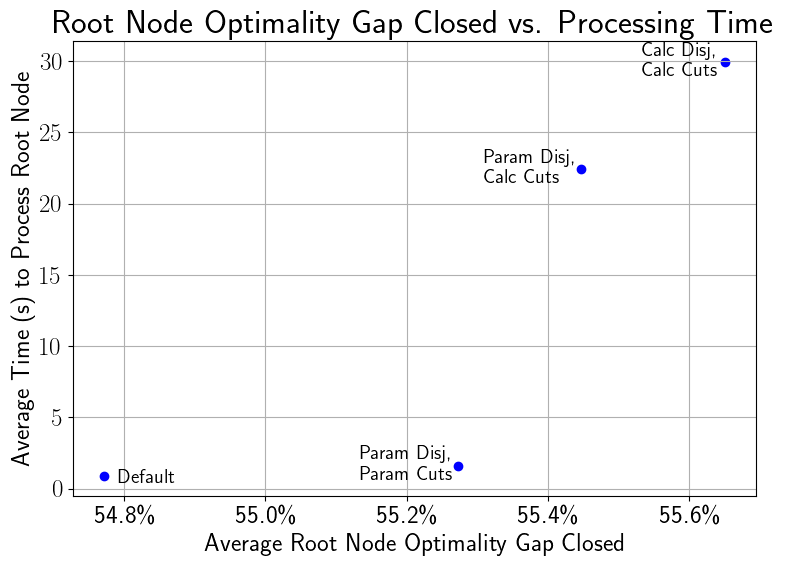

In [183]:
plt.rc('text', usetex=True)  # use latex fonts
plt.rcParams['font.size'] = 18

pareto_df = bound_df[[f for f in fields if "Root Cuts" in f or "rootDualBoundTime" in f]].mean().reset_index()
pareto_df.columns = ["key", "value"]

# Extract strength and time rows
strength_df = pareto_df[pareto_df['key'].str.contains("Root Cuts")].copy()
strength_df['category'] = strength_df['key'].str.extract(r'\((.*?)\)')
# strength_df["value"] = 100 * strength_df["value"]

time_df = pareto_df[pareto_df['key'].str.contains("rootDualBoundTime")].copy()
time_df['category'] = time_df['key'].str.extract(r'(None|Farkas|Old|New)')

# Merge data on category
merged_df = pd.merge(strength_df, time_df, on='category', suffixes=('_strength', '_time'))

# update column names
cat_map = {
    "None": "Default",
    "Farkas": "Param Disj,\nParam Cuts",
    "Old": "Param Disj,\nCalc Cuts",
    "New": "Calc Disj,\nCalc Cuts"
}
merged_df['category'] = merged_df['category'].replace(cat_map)

# Create plot
plt.figure(figsize=(8, 6))
plt.scatter(merged_df['value_strength'], merged_df['value_time'], color='blue', label='Data Points')
plt.xlabel("Average Root Node Optimality Gap Closed")
plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0, 1))
plt.ylabel("Average Time (s) to Process Root Node")
plt.title("Root Node Optimality Gap Closed vs. Processing Time", fontsize=24)
plt.grid(True)

# Annotate points with categories
for _, row in merged_df.iterrows():
    offset = (10, -5) if row['category'] == "Default" else (-60, -10) if "Param" not in row["category"] else (-70, -10)
    plt.annotate(row['category'], (row['value_strength'], row['value_time']),
                 textcoords="offset points", xytext=offset, fontsize=14)

plt.tight_layout()

plt.savefig(os.path.join(
    out_fldr, f"strength_vs_time.png"
), dpi=1200)

plt.show()

In [184]:
# # Step 1: Group by 'instance' and count unique 'perturbation' values
# shared_instances = bound_df.groupby('instance')['perturbation'].nunique()
# 
# # Step 2: Filter to instances with exactly 3 unique perturbations
# shared_instances = shared_instances[shared_instances == 3].index
# 
# # Step 3: Filter the original DataFrame and see now what it looks like for using the same base instances throughout
# bound_df[bound_df['instance'].isin(shared_instances)].groupby(["degree", "terms", "perturbation"]).agg(aggregations).reset_index()

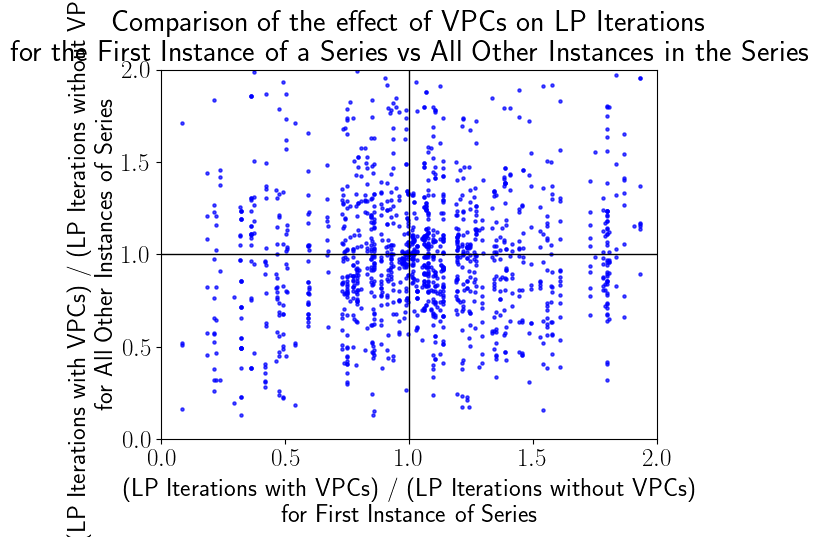

In [185]:
# if cuts helped for the base instance, do they for others?
# set which metric to compare
metric = "iteration"
name_map = {
    "terminationTime": "Running Time",
    "node": "Nodes Processed",
    "iteration": "LP Iterations",
}

# get all unique combinations of instance and perturbation in triples
unique_combinations = triples[['instance', 'perturbation']].drop_duplicates()

# append to each the first instance in the series so we can append their data later
unique_combinations["instanceIndex"] = 0

# get the data for the first instance runs
bound_start_df =full_df.merge(unique_combinations, on=["instance", "perturbation", "instanceIndex"])[group_cols + id_cols + fields]
data_df = bound_start_df.merge(bound_df, on=group_cols, suffixes=(" Initial", " Test"))

# make a scatter plot of the two metrics with terminationTimeRatio Initial on the x-axis and terminationTimeRatio Test on the y-axis
plt.scatter(data_df[f"{metric}Ratio Initial"], data_df[f"{metric}Ratio Test"],
            marker='o', color='blue', s=5, alpha=.7)
plt.xlabel(f"({name_map[metric]} with VPCs) / ({name_map[metric]} without VPCs)\nfor First Instance of Series")
plt.ylabel(f"({name_map[metric]} with VPCs) / ({name_map[metric]} without VPCs)\nfor All Other Instances of Series")
plt.xlim(0, 2)
plt.ylim(0, 2)   
# add horizontal and vertical lines at 1
plt.axhline(1, color='black', lw=1)
plt.axvline(1, color='black', lw=1)
plt.title(f"Comparison of the effect of VPCs on {name_map[metric]}\nfor the First Instance of a Series vs All Other Instances in the Series")
plt.savefig(os.path.join(out_fldr, f"{metric}_ratio_initial_vs_test.png"))
plt.show()

## Make Profiles

In [186]:
def make_plots(prof_df, metric, show_all=False, perturbation=None, exclude_perturbation=False, threshold=None):
    
    plt.rc('text', usetex=True)  # use latex fonts

    label = {
        "postRootTime": "Time after Processing Root Node",
        "rootDualBoundTimeSansVpc": "Root Processing Time (Minus VPC Generation)",
        "terminationTimeSansVpc": "Time (Minus VPC Generation)",
        "terminationTime": "Time",
        "nodes": "Nodes Processed",
        "iterations": "LP Iterations",
    }
    unit = {
        "postRootTime": "(seconds)",
        "rootDualBoundTimeSansVpc": "(seconds)",
        "terminationTimeSansVpc": "(seconds)",
        "terminationTime": "(seconds)",
        "nodes": "(1000 nodes)",
        "iterations": "(1000 iterations)",
    }
    
    # Unique values in 'degree' and 'terms'
    unique_degrees = prof_df['degree'].sort_values(ascending=False).unique()  # sort increasing
    unique_terms = prof_df['terms'].sort_values().unique()  # sort decreasing
    
    # Create subplots for a grid
    fig, axes = plt.subplots(len(unique_degrees), len(unique_terms),
                             figsize=(4*len(unique_terms), 4*len(unique_degrees)))
    
    for i, degree in enumerate(unique_degrees):
        for j, terms in enumerate(unique_terms):
            ax = axes[i, j]
    
            # Filter the DataFrame based on 'degree' and 'terms'
            subset_df = prof_df[(prof_df['degree'] == degree) & (prof_df['terms'] == terms)]  
            
            # if we are looking at a specific perturbation, filter for it
            if perturbation is not None:
                subset_df = subset_df[subset_df["perturbation"] == perturbation]
              
            # if we want to filter for a threshold of top % time improvement, do so  
            if threshold is not None:
                cut_off = subset_df["terminationTimeImprovement"].quantile(1 - threshold)
                subset_df = subset_df[subset_df["terminationTimeImprovement"] >= cut_off]
            
            # get our data
            # plug in below to calibrate limits
            # int(prof_df[[f"{metric} Farkas", f"{metric} None"]].max().max())
            limits = {
                "postRootTime": 7200,
                "terminationTimeSansVpc": 7200,
                "terminationTime": 7200,
                "rootDualBoundTimeSansVpc": 5,
                "nodes": 10000,
                "iterations": 50000
            }
            x = range(limits[metric])
            y_farkas = [(subset_df[f"{metric} Farkas"] < i).sum() / len(subset_df) for i in x]        
            y_none = [(subset_df[f"{metric} None"] < i).sum() / len(subset_df) for i in x]
            y_old = [(subset_df[f"{metric} New"] < i).sum() / len(subset_df) for i in x]        
            y_new = [(subset_df[f"{metric} Old"] < i).sum() / len(subset_df) for i in x]
            
            # make our plot
            ax.plot(x, y_none, label="Default")
            if show_all:
                ax.plot(x, y_old, label="Calc Disj, Calc Cuts")
                ax.plot(x, y_new, label="Param Disj, Calc Cuts")
            ax.plot(x, y_farkas, label="Param Disj, Param Cuts")
            
            # Highlight the region where Farkas VPCs have solved more instances than None
            fill_region = np.array([y_farkas[i] > y_none[i] for i in x])
            ax.fill_between(x, y_none, y_farkas, facecolor='yellow', alpha=0.3, where=fill_region, label="Improvement of Param Disj,\nParam Cuts over Default")
            
            # set labels
            if j == 0:
                ax.set_ylabel("Proportion of Instances with\nPrimal-Dual Gap $\leq 10^{-4}$")
            if i == len(unique_degrees) - 1:
                ax.set_xlabel(label[metric] + " " + unit[metric])
            ax.set_title(f"{degree} Degree{'s' if degree >= 2 else ''} of Perturbation,\n{terms} Disjunctive Terms")
            
            # set y axis
            ax.set_ylim(0.8, 1.05)
    
    
    fig.suptitle(f'{"Number of " if "Time" not in metric else ""}'
                 f'{label[metric]} to Solve Perturbations of MIPLIB3 '
                 f'Instances to Optimality\n'  # (at most 1000 Constraints and Variables'
                 f'{"perturbing only " + perturbation if perturbation else ""}'
                 f'{"(top " + str(int(threshold * 100)) + " percent most improved Param Disj, Param Cuts vs Default)" if threshold else ""}',
                 fontsize=24)

    # Adjust layout to make space for the legend below the plots
    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space at the bottom for the legend
    
    # Add the legend below the subplots
    handles, labels = ax.get_legend_handles_labels()  # Get legend elements from the last axis
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=5, fontsize=12)
    
    # Save the figure with tight layout
    plt.savefig(os.path.join(
        out_fldr, f"{metric}{'_'+perturbation if perturbation else ''}.png"
    ), dpi=1200, bbox_inches='tight')

    plt.show()

## Make time table

In [75]:
# additional filtering for dataframe on run time
fields = ["terminationTime New", "terminationTime Old",
          "terminationTime Farkas", "terminationTime None",
          "terminationTimeSansVpc New", "terminationTimeSansVpc Old",
          "terminationTimeSansVpc Farkas", "terminationTimeSansVpc None",
          "rootDualBoundTimeSansVpc New", "rootDualBoundTimeSansVpc Old",
          "rootDualBoundTimeSansVpc Farkas", "rootDualBoundTimeSansVpc None",
          "postRootTime New", "postRootTime Old",
          "postRootTime Farkas", "postRootTime None",
          "vpcGenerationTime New", "vpcGenerationTime Old",
          "vpcGenerationTime Farkas", "terminationTimeImprovement"]
# only check perturbed instances that solve to optimality and VPC didn't find optimal solution
mask = mask & (optimality_gap(df, "New") <= 1e-4) & \
    (optimality_gap(df, "None") <= 1e-4) & (optimality_gap(df, "Farkas") <= 1e-4) & \
       (df["terminationTime None"] > min_termination_time)
if remove_status_changes:
    mask = mask & (df["infeasibleToFeasibleTermsRatio Farkas"] == 0) & (df["feasibleToInfeasibleTermsRatio Farkas"] == 0)
time_df =full_df.loc[mask, group_cols + id_cols + fields]

# define aggregating operations
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

# get gap closed by degree and term
out = time_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "time.csv"), index=False, mode="w")
out

,degree,terms,terminationTime New,terminationTime Old,terminationTime Farkas,terminationTime None,terminationTimeSansVpc New,terminationTimeSansVpc Old,terminationTimeSansVpc Farkas,terminationTimeSansVpc None,...,postRootTime New,postRootTime Old,postRootTime Farkas,postRootTime None,vpcGenerationTime New,vpcGenerationTime Old,vpcGenerationTime Farkas,terminationTimeImprovement,instance,instanceIndex
0,0.5,4,662.207455,558.284955,323.594571,319.220433,328.099819,341.078531,323.412242,319.220433,...,325.530413,338.502214,320.739082,316.642389,334.107636,217.206423,0.182329,-0.203579,118,811
1,0.5,16,711.865491,630.851258,362.450276,323.200883,370.630070,355.004097,361.424283,323.200883,...,368.591661,352.999445,359.350973,321.110973,341.235421,275.847161,1.025993,-0.246122,106,618
2,0.5,64,495.747672,514.048941,406.537978,353.842781,403.479971,415.775530,404.622012,353.842781,...,402.299796,414.610597,403.468503,352.719704,92.267700,98.273411,1.915966,-0.342912,84,415
3,2.0,4,1600.091618,584.940977,335.645030,313.961412,321.196212,327.553005,335.384307,313.961412,...,318.555964,324.869042,332.469518,311.199123,1278.895406,257.387972,0.260723,-0.448620,114,743
4,2.0,16,820.492812,727.749839,375.096160,347.116026,377.805444,382.924598,372.558857,347.116026,...,375.689703,380.886056,370.461390,344.984738,442.687368,344.825241,2.537303,-0.603313,103,605
5,2.0,64,473.557344,524.814660,342.382500,336.176637,364.313688,371.524412,340.156303,336.176637,...,362.989662,370.215668,338.870845,334.845178,109.243656,153.290248,2.226196,-0.258577,86,416


In [76]:
time_df

,instance,perturbation,degree,terms,instanceIndex,terminationTime New,terminationTime Old,terminationTime Farkas,terminationTime None,terminationTimeSansVpc New,...,rootDualBoundTimeSansVpc Farkas,rootDualBoundTimeSansVpc None,postRootTime New,postRootTime Old,postRootTime Farkas,postRootTime None,vpcGenerationTime New,vpcGenerationTime Old,vpcGenerationTime Farkas,terminationTimeImprovement
23,aligninq,matrix,0.5,4,1,855.151586,400.647945,295.944097,313.462830,850.564405,...,2.823675,2.495658,847.778898,301.723837,292.333877,310.967172,4.587181,96.262974,0.786545,0.055888
24,aligninq,matrix,0.5,4,2,241.382172,700.075363,256.155254,401.255080,239.116532,...,3.903982,3.526217,235.578254,263.132003,251.417344,397.728863,2.265640,432.279965,0.833928,0.361615
25,aligninq,matrix,0.5,4,3,142.638999,293.994977,183.338227,86.801911,139.586234,...,4.151264,3.803438,136.022449,204.625363,178.423026,82.998473,3.052765,85.698215,0.763937,-1.112145
26,aligninq,matrix,0.5,4,4,192.929587,227.480413,88.845049,61.460302,190.435371,...,3.636543,3.620650,187.128318,144.757016,84.479424,57.839652,2.494216,78.868472,0.729082,-0.445568
28,n7-3,matrix,0.5,4,1,52.640795,39.971937,52.902455,34.773554,44.988131,...,2.023700,2.064829,43.000260,34.324911,50.675030,32.708725,7.652664,3.718599,0.203725,-0.521342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9551,gsvm2rl3,matrix,2.0,16,1,218.368167,156.849046,238.783435,65.797010,212.958211,...,0.168938,0.206727,212.756137,153.428687,238.456494,65.590283,5.409956,3.194647,0.158003,-2.629092
9552,gsvm2rl3,matrix,2.0,16,2,21.449512,8.586893,8.765791,12.172628,15.899727,...,0.218623,0.193777,15.718343,5.215814,8.376018,11.978851,5.549785,3.124329,0.171150,0.279877
9553,gsvm2rl3,matrix,2.0,16,3,336.711445,214.459550,115.760170,232.243623,331.022046,...,0.202596,0.201794,330.782954,211.318033,115.407992,232.041829,5.689399,2.948587,0.149582,0.501557
9554,gsvm2rl3,matrix,2.0,16,4,280.430683,333.280523,412.889122,573.160644,276.047617,...,0.184537,0.133517,275.898977,330.467542,412.567342,573.027127,4.383066,2.632865,0.137243,0.279628


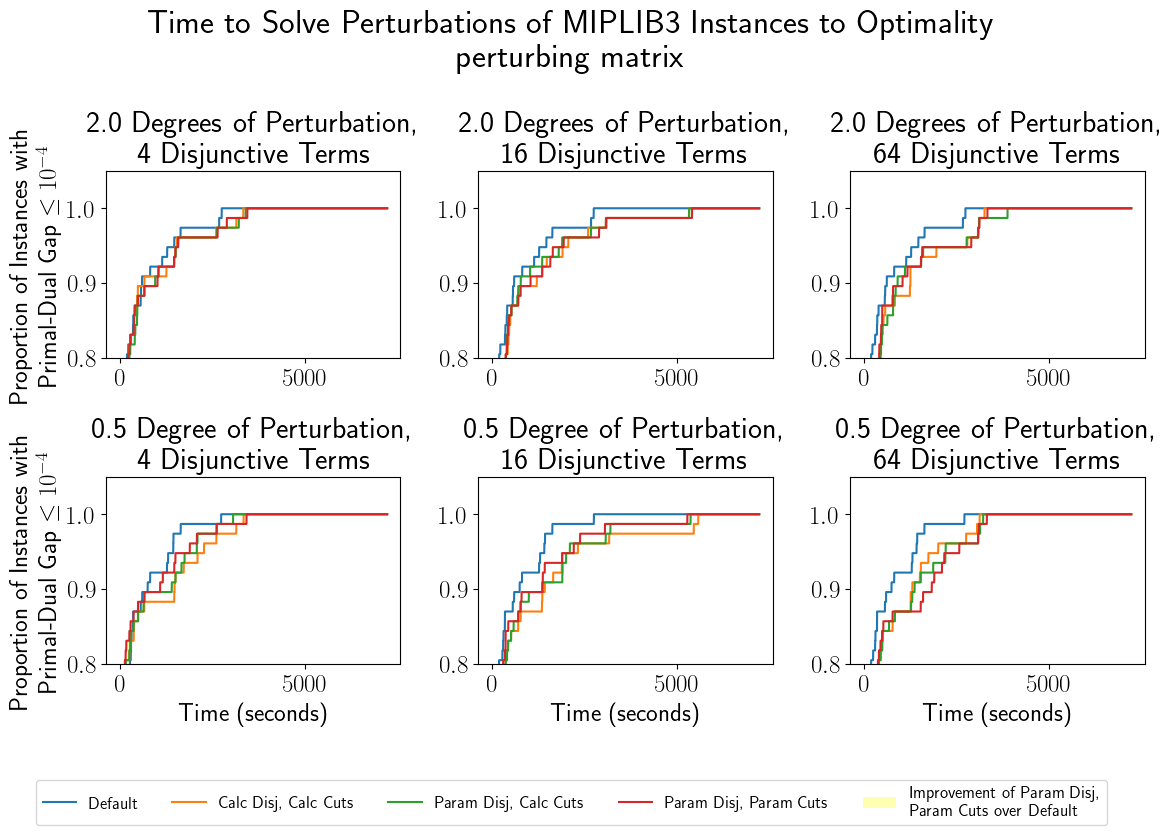

In [187]:
make_plots(time_df, "terminationTime", show_all=True)

# Make node table

In [78]:
# additional filtering for dataframe on nodes processed
fields = ["nodes New", "nodes Old", "nodes Farkas",
          "nodes None", "terminationTimeImprovement"]
node_df =full_df.loc[mask, group_cols + id_cols + fields]
for f in fields:
    node_df[f] = node_df[f] / 1000

# define aggregating operations
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

# get gap closed by degree and term
out = node_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "node.csv"), index=False, mode="w")
out

,degree,terms,nodes New,nodes Old,nodes Farkas,nodes None,terminationTimeImprovement,instance,instanceIndex
0,0.5,4,357.795652,379.637613,347.593729,358.103836,-0.000204,118,811
1,0.5,16,305.790638,313.473479,308.173222,291.005129,-0.000246,106,618
2,0.5,64,545.061123,579.467108,556.128429,554.299805,-0.000343,84,415
3,2.0,4,282.801847,290.228062,280.180363,280.711122,-0.000449,114,743
4,2.0,16,334.230711,349.485769,341.049926,326.451975,-0.000603,103,605
5,2.0,64,381.422687,380.588899,364.739594,356.740707,-0.000259,86,416


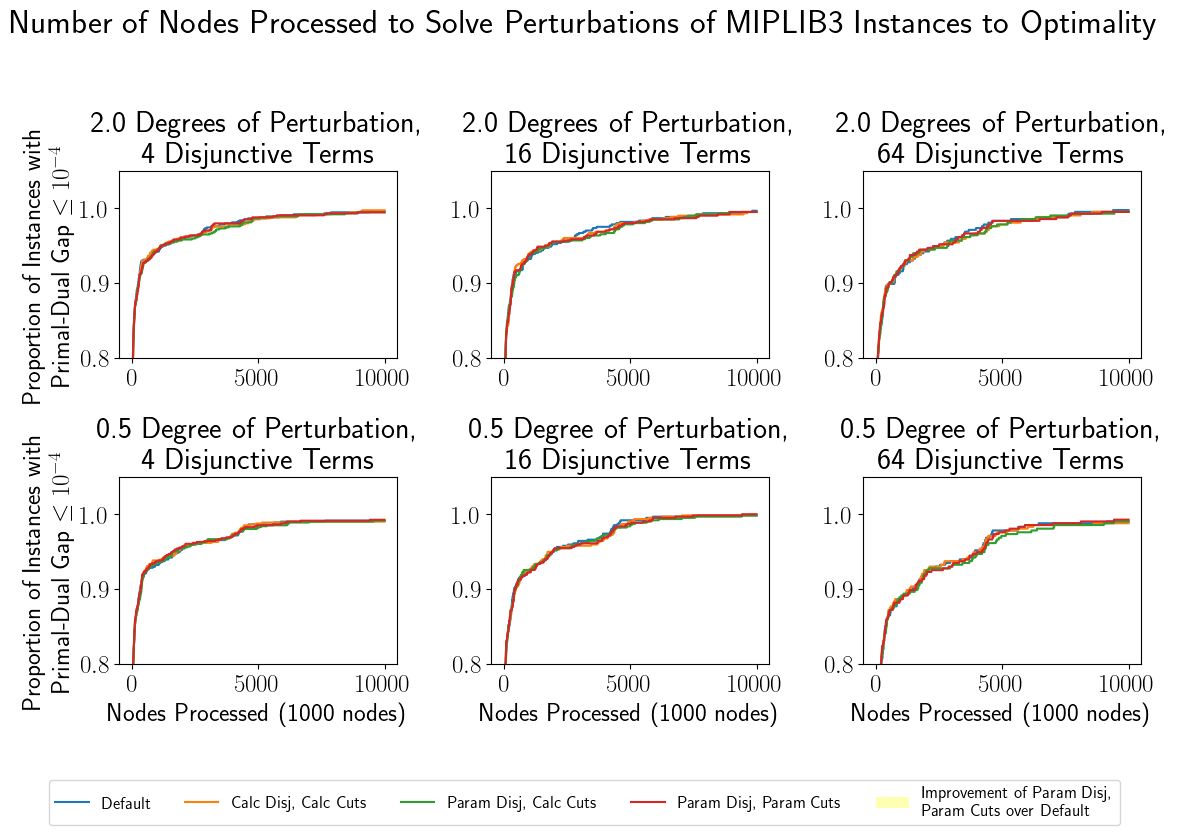

In [79]:
make_plots(node_df, "nodes", show_all=True)

# Make iteration table

In [80]:
# additional filtering for dataframe on nodes processed
fields = ["iterations New", "iterations Old",
          "iterations Farkas", "iterations None",
          "terminationTimeImprovement"]
iteration_df =full_df.loc[mask, group_cols + id_cols + fields]
for f in fields:
    iteration_df[f] = iteration_df[f] / 1000

# define aggregating operations
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

# get gap closed by degree and term
out = iteration_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "iteration.csv"), index=False, mode="w")
out

,degree,terms,iterations New,iterations Old,iterations Farkas,iterations None,terminationTimeImprovement,instance,instanceIndex
0,0.5,4,2443.039882,2578.023571,2392.524048,2449.508674,-0.000204,118,811
1,0.5,16,2531.314152,2530.566558,2527.541364,2391.703068,-0.000246,106,618
2,0.5,64,3326.159581,3517.082417,3411.499154,3348.132337,-0.000343,84,415
3,2.0,4,2187.252843,2309.106696,2207.179685,2164.016670,-0.000449,114,743
4,2.0,16,2512.995636,2720.447555,2583.625038,2480.959785,-0.000603,103,605
5,2.0,64,2679.866887,2721.155101,2555.220731,2595.030603,-0.000259,86,416


In [81]:
# make_plots(iteration_df, "iterations", show_all=True)

## Improvement Consistency

In [116]:
# Define the custom formatter function
def multiply_by_100(x, pos):
    return '%1.0f' % (x * 100)

# Create a FuncFormatter object
formatter = FuncFormatter(multiply_by_100)

def make_run_time_boxplot(time_df, perturbation=None, threshold=.1, best=False):
    plt.rc('text', usetex=True)  # use latex fonts
    plt.rcParams['font.size'] = 18

    # Get unique values of degree and terms
    degrees = time_df['degree'].sort_values(ascending=False).unique()  # sort increasing
    terms = time_df['terms'].sort_values().unique()  # sort decreasing
    
    if best:
        degrees = [degrees[-1]]
        terms = [terms[-1]]
    
    # Create a grid of subplots
    fig, axes = plt.subplots(len(terms), len(degrees), figsize=(8*len(degrees), 4*len(terms)) if not best else (12, 6))
    
    # Iterate through each combination of degree and terms
    for i, term in enumerate(terms):
        for j, degree in enumerate(degrees):
            
            current_ax = axes if best else axes[i, j]
            
            # get the data for this combination
            subset = time_df[(time_df['terms'] == term) &
                             (time_df['degree'] == degree)]
            
            # if we are looking at a specific perturbation, filter for it
            if perturbation is not None:
                subset = subset[subset["perturbation"] == perturbation]
                
            cut_off = subset["terminationTimeImprovement"].quantile(1 - threshold)
            
            # now break it down by instance
            unique_instances = subset['instance'].sort_values().unique()
            instance_data = [subset[subset['instance'] == instance]['terminationTimeImprovement'].tolist()
                             for instance in unique_instances]
            
            # make all the boxplots for this plot
            current_ax.boxplot(instance_data, labels=unique_instances)
            current_ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=.5)
            if not best:
                current_ax.set_ylim(-3, 1)
                current_ax.set_xticklabels([])
            else:
                current_ax.set_xticklabels(current_ax.get_xticklabels(), rotation=90, fontsize=10)
                current_ax.set_ylim(-2, 1)
            current_ax.yaxis.set_major_formatter(formatter)  # Apply the custom formatter
            current_ax.set_title(f"{degree} Degree{'s' if degree >= 2 else ''} of Perturbation"
                                 + ('\n' if not best else ' and ') + f"{term} Disjunctive Terms")
            if j == 0:
                current_ax.set_ylabel('\% Improvement')
            # if i == len(terms) - 1 and (best or j == len(degrees)//2):
            #     current_ax.set_xlabel('(Each set of box and whiskers represents the perturbations of one presolved MIPLIB 2017 Instance)')
            
    
    if not best:
        fig.suptitle(f"Distributions of Relative Time Improvement for Param Disj, "
                     f"Param Cuts compared to Default"
                     f"{' - perturbing only ' + perturbation if perturbation else ''}\n"
                     f"(positive values imply Param Disj, Param Cuts'"
                     f" run time faster than Default's)")
        fig.text(0.5, 0.02, '(Each set of box and whiskers represents distribution of relative improvements for the perturbations of one presolved MIPLIB 2017 Instance)',
                 ha='center', va='center', fontsize=14)
    else:
        fig.suptitle(f"Relative Termination Time Improvements between Solves with and without Param. VPCs ", fontsize=24, x=.5, y=1.0)
    
    plt.tight_layout()
    plt.savefig(os.path.join(out_fldr, f"time_improvement_distribution_by_base_instance"
                                       f"{'_' + perturbation if perturbation else '_best' if best else ''}.png"),
                dpi=1200)
    if not best:
        plt.legend()
    plt.show()

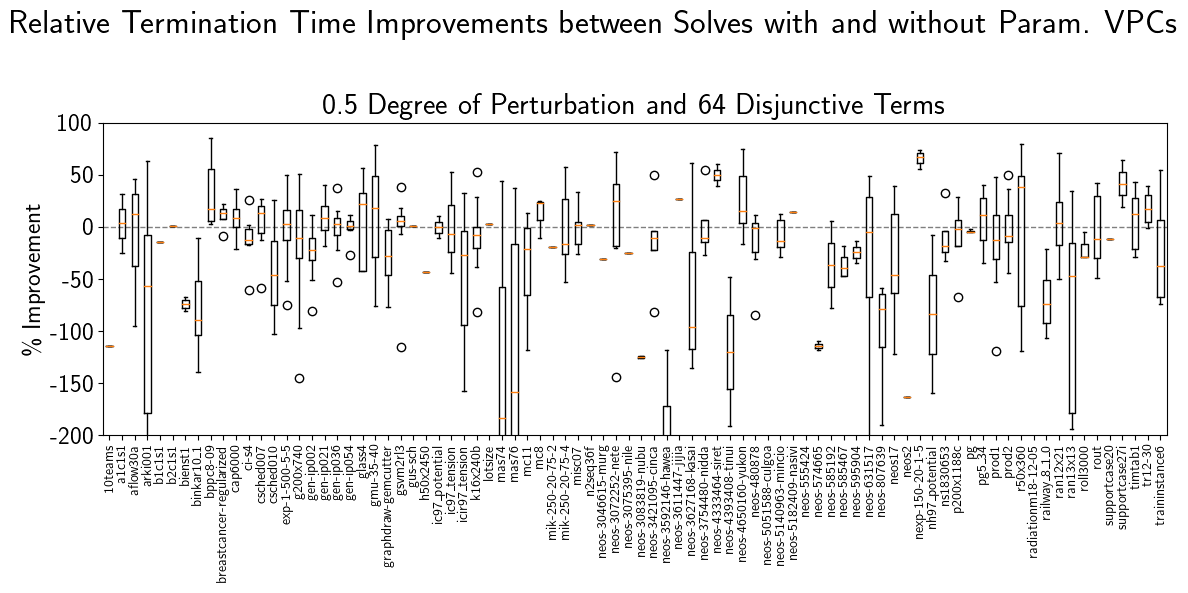

In [83]:
make_run_time_boxplot(time_df, best=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


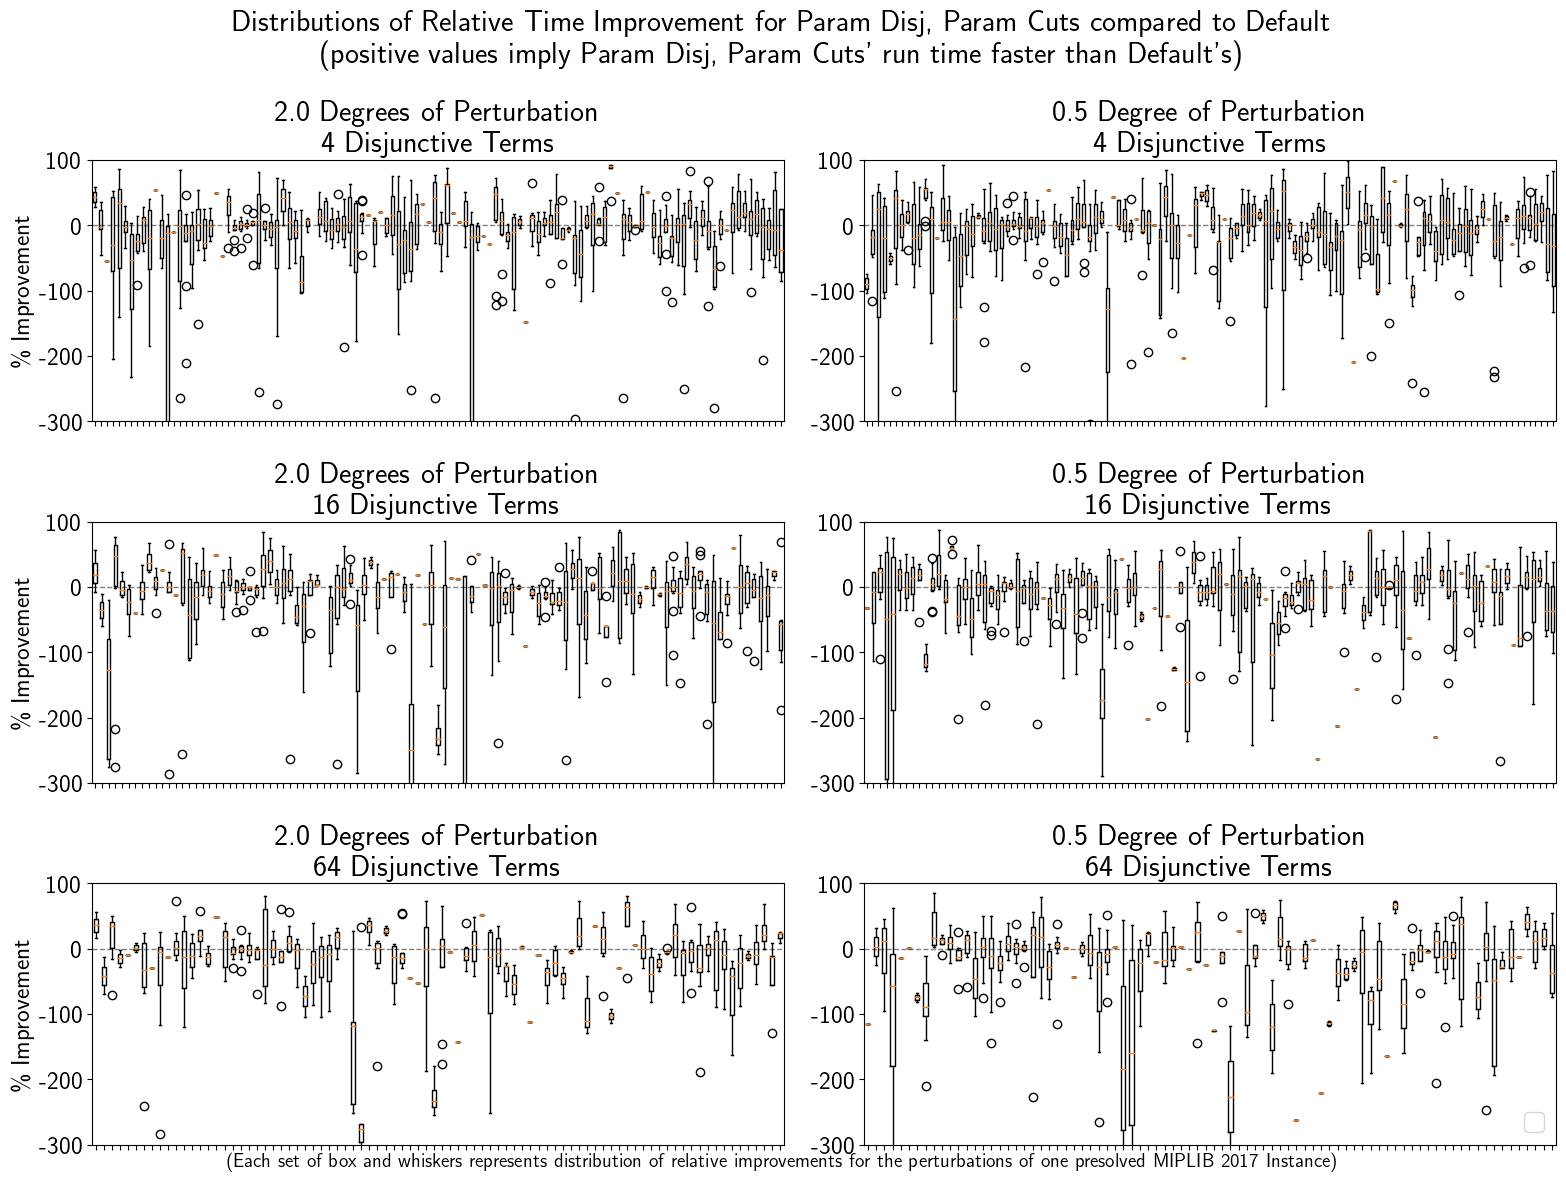

In [117]:
make_run_time_boxplot(time_df)

In [85]:
# get a table of all unperturbed instances that solved to optimality
df_zero = df_map["None"].loc[(df_map["None"]["instanceIndex"] == 0) & (optimality_gap(df_map["None"]) <= 1e-4) & (df_map["None"]["terminationTime"] > min_termination_time)]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


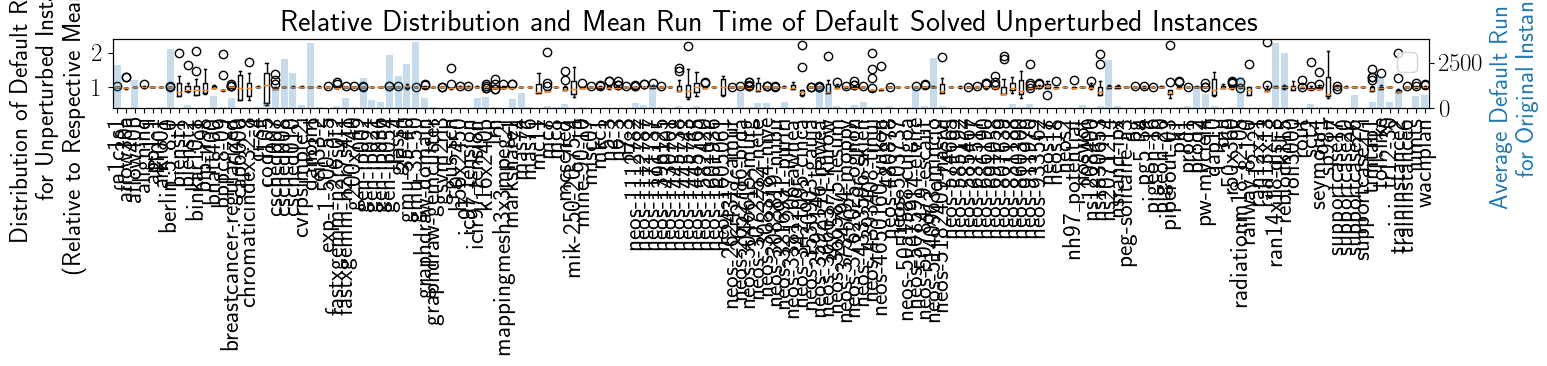

In [86]:
# configure plot
plt.rc('text', usetex=True)
fig, ax1 = plt.subplots(figsize=(16, 4))

# now break it down by instance
mean_run = df_zero.groupby("instance")["terminationTime"].mean().to_dict()
data = {instance: df_zero[df_zero['instance'] == instance]['terminationTime'].values / time
         for instance, time in mean_run.items()}

# make all the boxplots for this plot
ax1.boxplot(data.values(), labels=data.keys())
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_ylabel('Distribution of Default Run Times\nfor Unperturbed Instances\n'
               '(Relative to Respective Mean Run Time)')
ax1.set_title("Relative Distribution and Mean Run Time of Default Solved Unperturbed Instances")

# make the barchart for this plot
ax2 = ax1.twinx()
color = 'tab:blue'
plt.bar(np.arange(1, len(mean_run) + 1), mean_run.values(), alpha=.25, color=color)
ax2.set_ylabel('Average Default Run Times\nfor Original Instances', color=color)

plt.tight_layout()
plt.savefig(os.path.join(out_fldr, "original_distribution.png"), dpi=1200)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


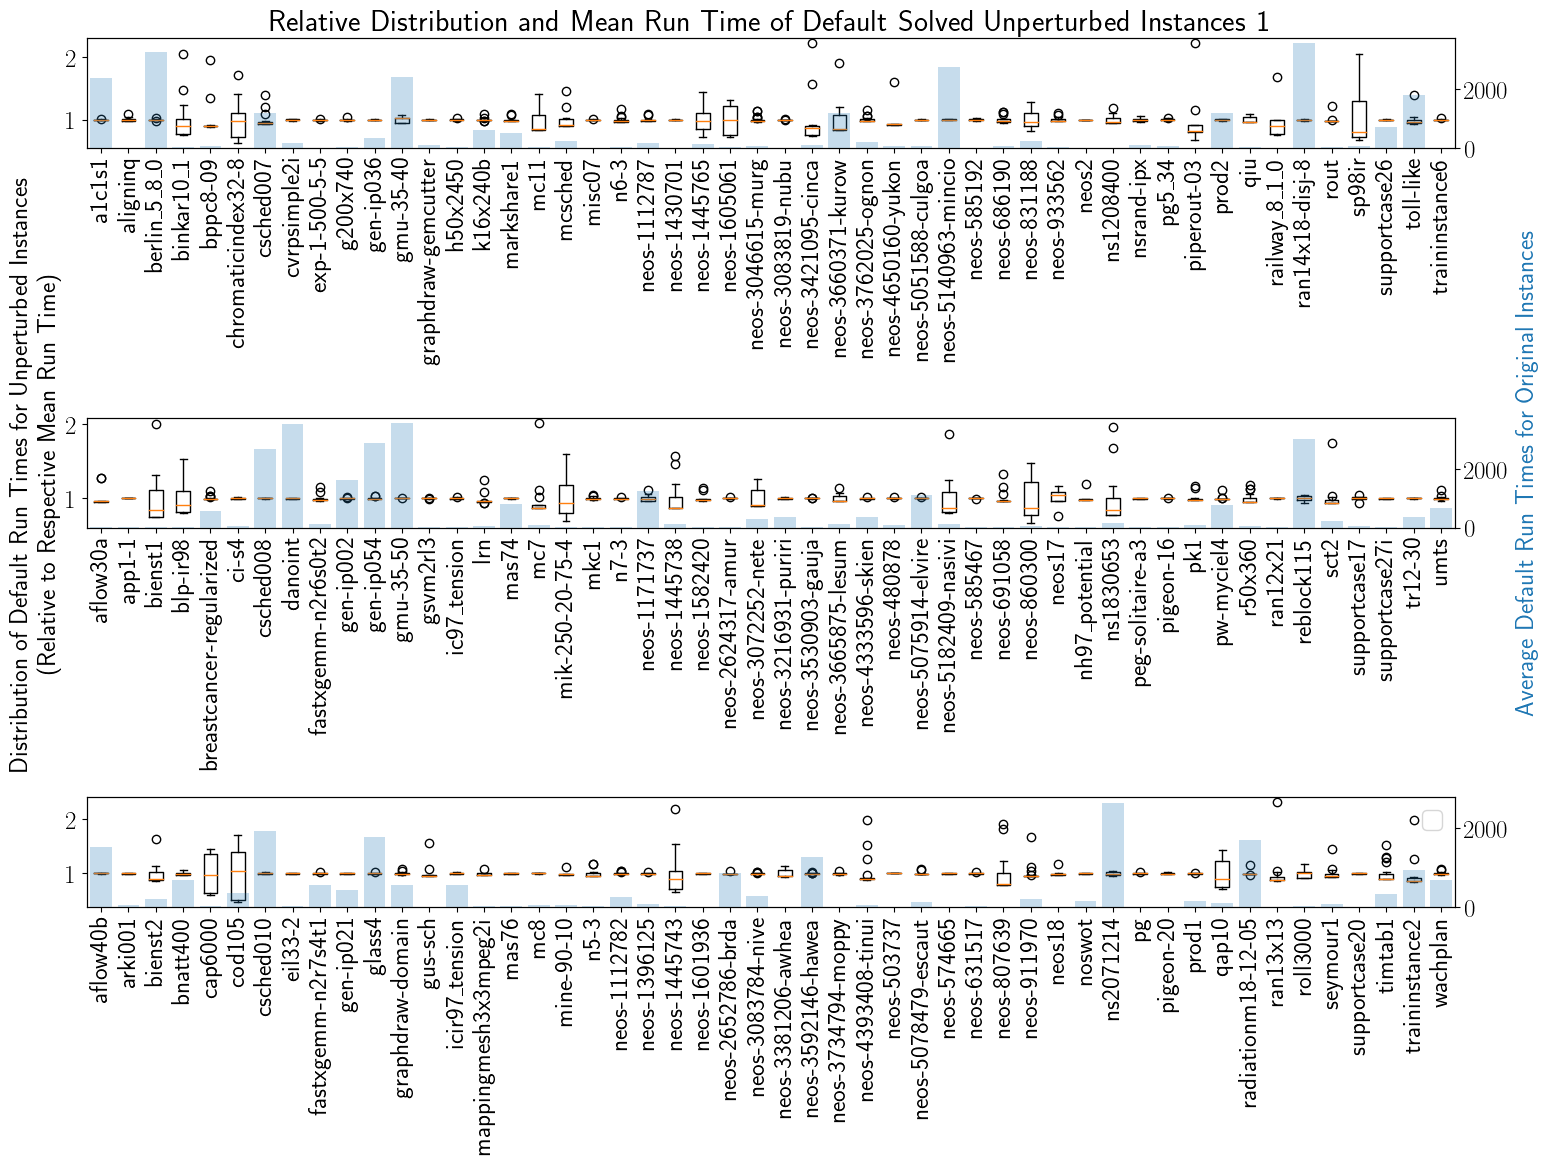

In [87]:
mean_run1 = {k: v for i, (k, v) in enumerate(mean_run.items()) if i % 3 == 0}
mean_run2 = {k: v for i, (k, v) in enumerate(mean_run.items()) if i % 3 == 1}
mean_run3 = {k: v for i, (k, v) in enumerate(mean_run.items()) if i % 3 == 2}
data1 = {k: data[k] for k in mean_run1}
data2 = {k: data[k] for k in mean_run2}
data3 = {k: data[k] for k in mean_run3}

datasets = [data1, data2, data3]
mean_runs = [mean_run1, mean_run2, mean_run3]
titles = ["Relative Distribution and Mean Run Time of Default Solved Unperturbed Instances 1",
          "Relative Distribution and Mean Run Time of Default Solved Unperturbed Instances 2",
          "Relative Distribution and Mean Run Time of Default Solved Unperturbed Instances 3"]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 12))

for i, (ax1, datax, mean_runx, title) in enumerate(zip(axes, datasets, mean_runs, titles)):
    # Create boxplot
    ax1.boxplot(datax.values(), labels=datax.keys())
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
    
    if i == 1:
        ax1.set_ylabel('Distribution of Default Run Times for Unperturbed Instances\n'
                       '(Relative to Respective Mean Run Time)')
    if i == 0:
        ax1.set_title(title)
    
    # Create bar chart
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.bar(np.arange(1, len(mean_runx) + 1), mean_runx.values(), alpha=.25, color=color)
    if i == 1:
        ax2.set_ylabel('Average Default Run Times for Original Instances', color=color)

plt.tight_layout()
plt.savefig(os.path.join(out_fldr, "original_distribution_stacked.png"), dpi=1200)
plt.legend()
plt.show()

## Check Root Optimality Gap Relationships

In [88]:
# these are the subset solved to optimality
# reasonable_std = [k for k, v in data.items() if v.std() < max_base_std]
gap_df = df.loc[mask] # & df["instance"].isin(reasonable_std)]  # & (df["terms"] == 64) & (df["degree"] == .5)]

In [89]:
gap_df.head()

,instanceIndex,vpcGenerator None,terms,lpBound None,disjunctiveDualBound None,lpBoundPostVpc None,rootDualBound None,dualBound None,primalBound None,vpcGenerationTime None,...,zeroInfeasibleToFeasibleTerms New,feasibleToInfeasibleTermsRatio New,infeasibleTermsRatio Old,infeasibleToFeasibleTermsRatio Old,zeroInfeasibleToFeasibleTerms Old,feasibleToInfeasibleTermsRatio Old,infeasibleTermsRatio Farkas,infeasibleToFeasibleTermsRatio Farkas,zeroInfeasibleToFeasibleTerms Farkas,feasibleToInfeasibleTermsRatio Farkas
23,1,None,4,2432.537572,2432.537572,2432.537572,2569.921087,2691.000000,2691.000000,0.000002,...,True,0.0,0.0,0.0,True,0.0,0.0,0.0,True,0.0
24,2,None,4,2455.531372,2455.531372,2455.531372,2647.265488,2724.000000,2724.000000,0.000003,...,True,0.0,0.0,0.0,True,0.0,0.0,0.0,True,0.0
25,3,None,4,2469.341086,2469.341086,2469.341086,2599.561430,2672.000000,2671.999997,0.000004,...,True,0.0,0.0,0.0,True,0.0,0.0,0.0,True,0.0
26,4,None,4,2522.739825,2522.739825,2522.739825,2649.593411,2708.000000,2708.000000,0.000002,...,True,0.0,0.0,0.0,True,0.0,0.0,0.0,True,0.0
28,1,None,4,12615.087316,12615.087316,12615.087316,15251.009957,15816.139514,15817.000000,0.000003,...,True,0.0,0.0,0.0,True,0.0,0.0,0.0,True,0.0


In [90]:
gap_df.columns

Index(['instanceIndex', 'vpcGenerator None', 'terms', 'lpBound None',
       'disjunctiveDualBound None', 'lpBoundPostVpc None',
       'rootDualBound None', 'dualBound None', 'primalBound None',
       'vpcGenerationTime None',
       ...
       'zeroInfeasibleToFeasibleTerms New',
       'feasibleToInfeasibleTermsRatio New', 'infeasibleTermsRatio Old',
       'infeasibleToFeasibleTermsRatio Old',
       'zeroInfeasibleToFeasibleTerms Old',
       'feasibleToInfeasibleTermsRatio Old', 'infeasibleTermsRatio Farkas',
       'infeasibleToFeasibleTermsRatio Farkas',
       'zeroInfeasibleToFeasibleTerms Farkas',
       'feasibleToInfeasibleTermsRatio Farkas'],
      dtype='object', length=145)

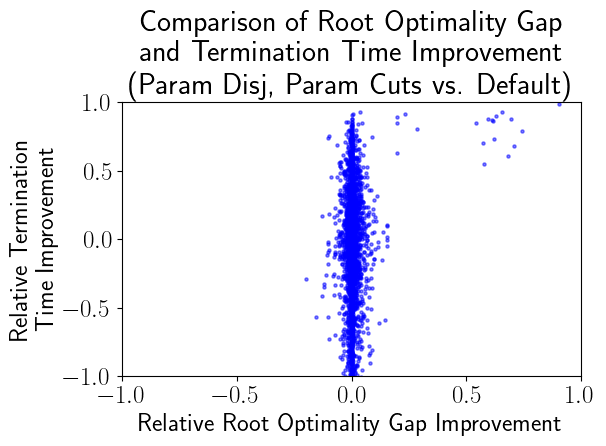

In [91]:
plt.scatter(gap_df["Root Optimality Gap Improvement"], gap_df["terminationTimeImprovement"],
            marker='o', color='blue', s=5, alpha=0.5)
plt.ylim(-1, 1)
plt.xlim(-1, 1)
plt.title("Comparison of Root Optimality Gap\nand Termination Time Improvement\n"
          "(Param Disj, Param Cuts vs. Default)")
plt.xlabel("Relative Root Optimality Gap Improvement")
plt.ylabel("Relative Termination\nTime Improvement")
plt.tight_layout()
plt.savefig(os.path.join(out_fldr, "gap_vs_time.png"), dpi=1200)
plt.show()

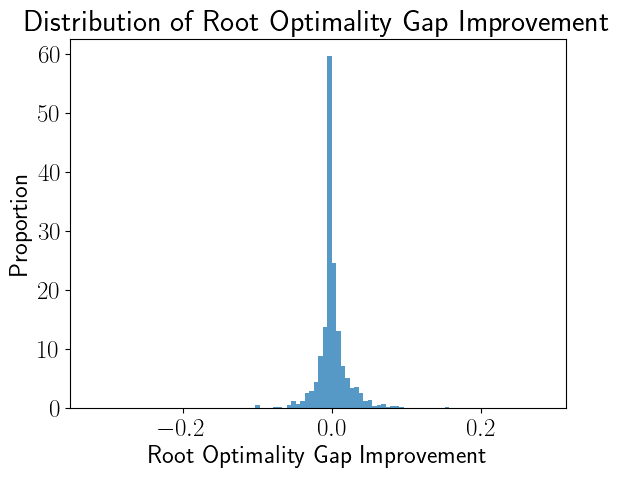

In [92]:
# Create a histogram with 100 bins
plt.hist(gap_df.loc[(-.5 < gap_df["Root Optimality Gap Improvement"]) & (gap_df["Root Optimality Gap Improvement"] < .5),
                    "Root Optimality Gap Improvement"], bins=100, density=True, alpha=0.75)

# Add labels and a title
plt.xlabel('Root Optimality Gap Improvement')
plt.ylabel('Proportion')
plt.title('Distribution of Root Optimality Gap Improvement')

# Display the plot
plt.show()

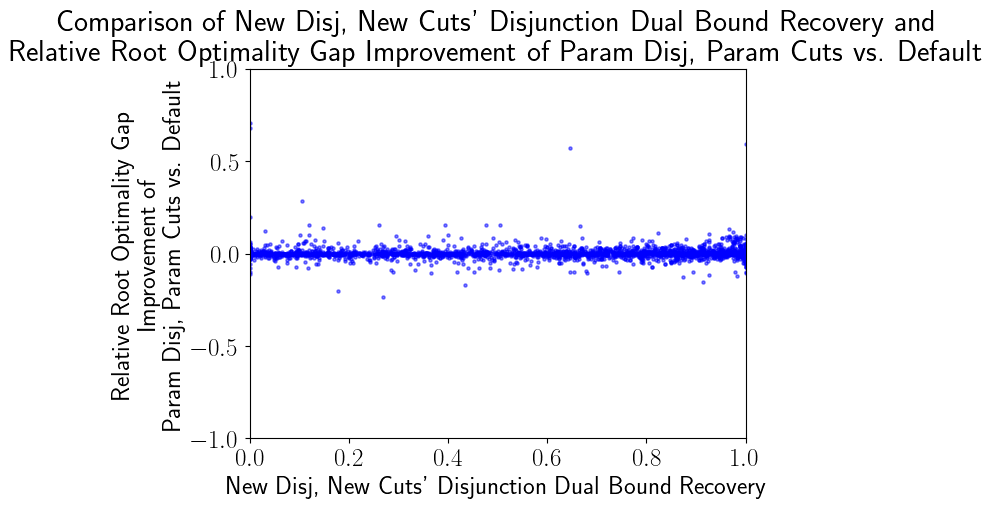

In [93]:
# is there a relationship between how much of dual bound we recover and root optimality gap improvement
plt.scatter(gap_df["VPCs (New)"] / gap_df["Disjunction (New)"],
            gap_df["Root Optimality Gap Improvement"],
            marker='o', color='blue', s=5, alpha=0.5)
plt.ylim(-1, 1)
plt.xlim(0, 1)
plt.title("Comparison of New Disj, New Cuts' Disjunction Dual Bound Recovery and\n"
          "Relative Root Optimality Gap Improvement of Param Disj, Param Cuts vs. Default")
plt.xlabel("New Disj, New Cuts' Disjunction Dual Bound Recovery")
plt.ylabel("Relative Root Optimality Gap\nImprovement of\nParam Disj, Param Cuts vs. Default")
plt.savefig(os.path.join(out_fldr, "vpc_dual_recover_vs_param_root_improvement.png"), dpi=1200)
plt.show()

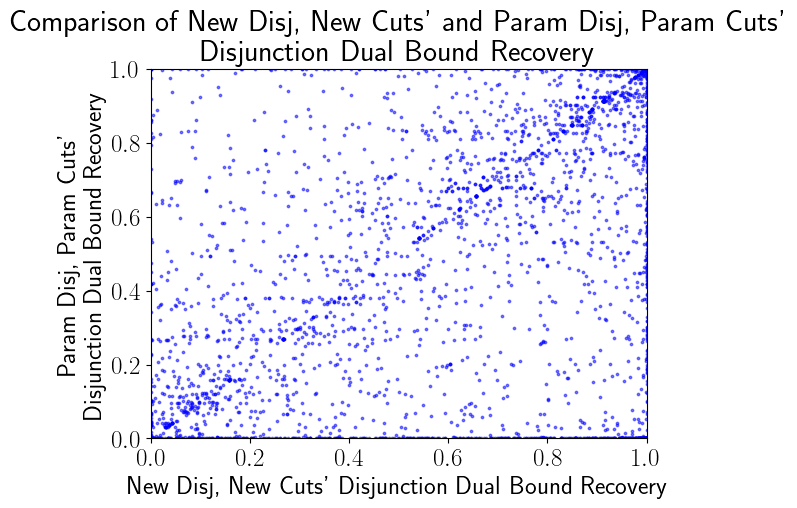

In [94]:
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
plt.scatter(gap_df["VPCs (New)"] / gap_df["Disjunction (New)"],
            gap_df["VPCs (Farkas)"] / gap_df["Disjunction (Old)"],
            marker='o', color='blue', s=3, alpha=0.5)
plt.title("Comparison of New Disj, New Cuts' and Param Disj, Param Cuts'\nDisjunction Dual Bound Recovery")
plt.xlabel("New Disj, New Cuts' Disjunction Dual Bound Recovery")
plt.ylabel("Param Disj, Param Cuts'\nDisjunction Dual Bound Recovery")
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.savefig(os.path.join(out_fldr, "vpc_vs_param_dual_bound_recover.png"), dpi=1200)
plt.show()  # todo: what happens when Param Disj, Param Cuts recovers the same amount of dual bound?

In [95]:
df.columns

Index(['instanceIndex', 'vpcGenerator None', 'terms', 'lpBound None',
       'disjunctiveDualBound None', 'lpBoundPostVpc None',
       'rootDualBound None', 'dualBound None', 'primalBound None',
       'vpcGenerationTime None',
       ...
       'zeroInfeasibleToFeasibleTerms New',
       'feasibleToInfeasibleTermsRatio New', 'infeasibleTermsRatio Old',
       'infeasibleToFeasibleTermsRatio Old',
       'zeroInfeasibleToFeasibleTerms Old',
       'feasibleToInfeasibleTermsRatio Old', 'infeasibleTermsRatio Farkas',
       'infeasibleToFeasibleTermsRatio Farkas',
       'zeroInfeasibleToFeasibleTerms Farkas',
       'feasibleToInfeasibleTermsRatio Farkas'],
      dtype='object', length=145)

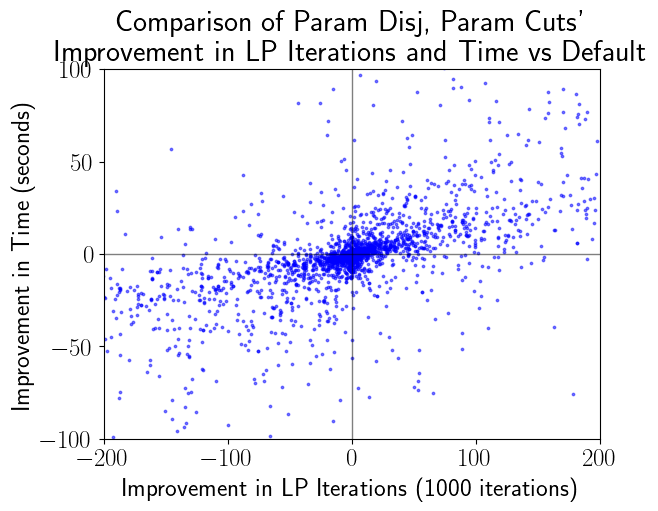

In [96]:
# plot iteration improvement over termination time improvement
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
plt.scatter(gap_df["iterations None"]/1000 - gap_df["iterations Farkas"]/1000,
            gap_df["terminationTime None"] - gap_df["terminationTime Farkas"],
            marker='o', color='blue', s=3, alpha=0.5)
plt.xlim(-200, 200)
plt.ylim(-100, 100)
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.axhline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.title("Comparison of Param Disj, Param Cuts'\nImprovement in LP Iterations and Time vs Default")
plt.xlabel("Improvement in LP Iterations (1000 iterations)")
plt.ylabel("Improvement in Time (seconds)")
plt.savefig(os.path.join(out_fldr, "lp_iters_vs_time.png"), dpi=1200)
plt.show()

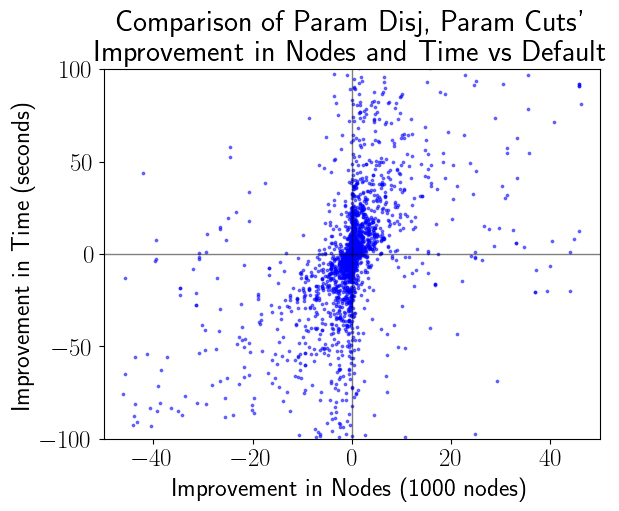

In [97]:
# plot iteration improvement over termination time improvement
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
plt.scatter(gap_df["nodes None"]/1000 - gap_df["nodes Farkas"]/1000,
            gap_df["terminationTime None"] - gap_df["terminationTime Farkas"],
            marker='o', color='blue', s=3, alpha=0.5)
plt.xlim(-50, 50)
plt.ylim(-100, 100)
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.axhline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.title("Comparison of Param Disj, Param Cuts'\nImprovement in Nodes and Time vs Default")
plt.xlabel("Improvement in Nodes (1000 nodes)")
plt.ylabel("Improvement in Time (seconds)")
plt.savefig(os.path.join(out_fldr, "nodes_vs_time.png"), dpi=1200)
plt.show()

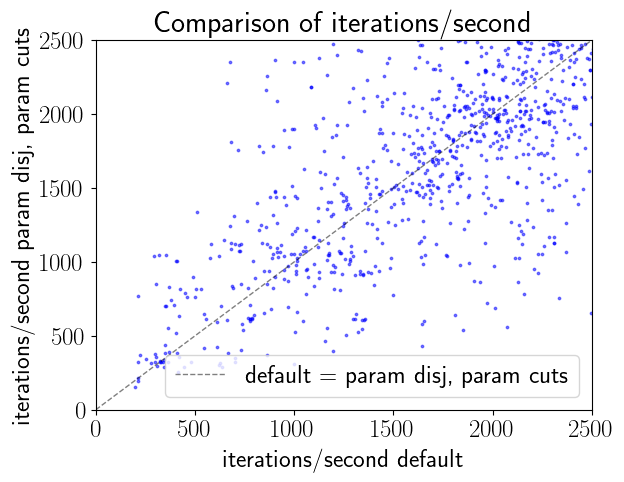

In [98]:
# plot iteration improvement over termination time improvement
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
plt.scatter(gap_df["iterations Farkas"]/gap_df["terminationTimeSansVpc Farkas"],
            gap_df["iterations None"]/gap_df["terminationTimeSansVpc None"],
            marker='o', color='blue', s=3, alpha=0.5)
# plot the line y = x
x = np.linspace(0, 3000, 3000)
plt.plot(x, x, linestyle='--', color='black', linewidth=1, alpha=.5,
         label="default = param disj, param cuts")
plt.xlim(0, 2500)
plt.ylim(0, 2500)
plt.title("Comparison of iterations/second")
plt.xlabel("iterations/second default")
plt.ylabel("iterations/second param disj, param cuts")
plt.legend()
plt.savefig(os.path.join(out_fldr, "lp_iters_per_second.png"), dpi=1200)
plt.show()

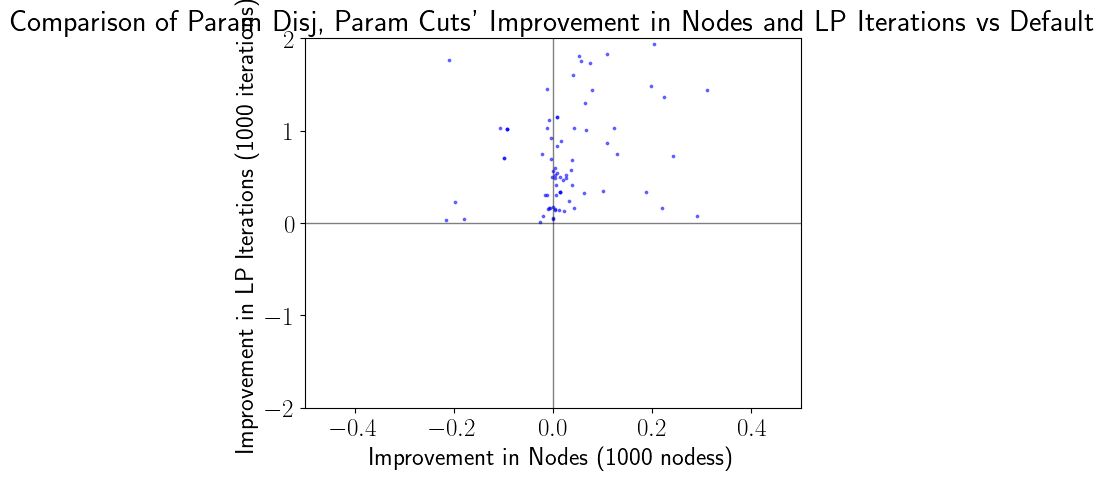

In [99]:
# plot node improvement over iteration improvement
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
tdf = gap_df.loc[(gap_df["iterationImprovement"] > 0) & (gap_df["terminationTimeImprovement"] < 0)]
plt.scatter(tdf["nodes None"]/1000 - tdf["nodes Farkas"]/1000,
            tdf["iterations None"]/1000 - tdf["iterations Farkas"]/1000,
            marker='o', color='blue', s=3, alpha=0.5)
plt.xlim(-.5, .5)
plt.ylim(-2, 2)
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.axhline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.title("Comparison of Param Disj, Param Cuts' Improvement in Nodes and LP Iterations vs Default")
plt.xlabel("Improvement in Nodes (1000 nodess)")
plt.ylabel("Improvement in LP Iterations (1000 iterations)")
plt.savefig(os.path.join(out_fldr, "nodes_vs_lp_iters_werid.png"), dpi=1200)
plt.show()

/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_23454/4127088869.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f"{int(x*100)}" for x in plt.gca().get_xticks()])


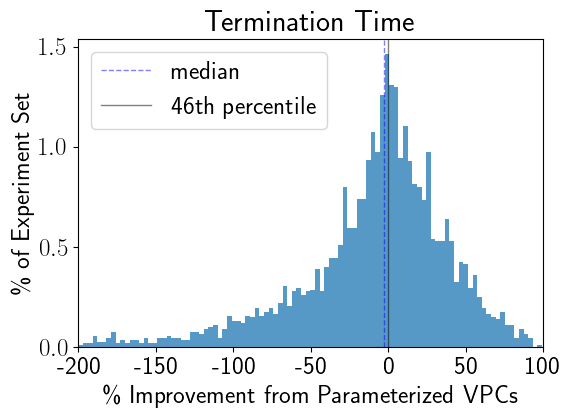

In [100]:
plt.rc('text', usetex=True)
plt.rcParams['font.size'] = 18
plt.figure(figsize=(6, 4))

# Create a histogram with 600 bins
plt.hist((gap_df["terminationTime None"] - gap_df["terminationTime Farkas"])/gap_df["terminationTime None"],
         bins=5000, density=True, alpha=0.75)
plt.xlim(-2, 1)

cut_off = ((gap_df["terminationTime None"] - gap_df["terminationTime Farkas"])/gap_df["terminationTime None"]).quantile(.5)
zeroth_percentile = int(100 * round((gap_df["terminationTime None"] >= gap_df["terminationTime Farkas"]).sum() / len(gap_df), 2))
plt.axvline(cut_off, color='blue', linestyle='--', linewidth=1, alpha=.5, label=f"median")
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5, label=f"{zeroth_percentile}th percentile")

# Add labels and a title
plt.xlabel('\% Improvement from Parameterized VPCs')
plt.gca().set_xticklabels([f"{int(x*100)}" for x in plt.gca().get_xticks()])
plt.ylabel('\% of Experiment Set')
plt.title('Termination Time')

# Display the plot
plt.legend()
plt.savefig(os.path.join(out_fldr, "time_improvement_distribution.png"), dpi=1200)
plt.show()

/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_23454/1940331930.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f"{int(x*100)}" for x in plt.gca().get_xticks()])


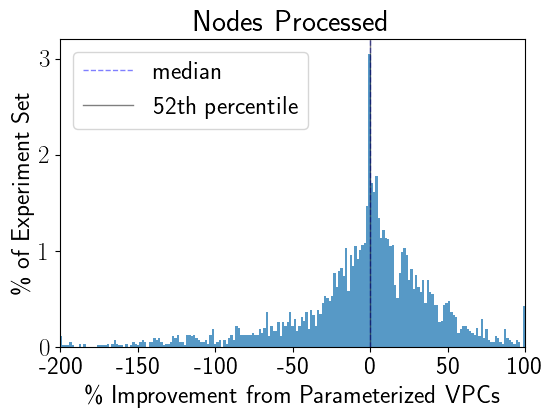

In [101]:
plt.rc('text', usetex=True)
plt.rcParams['font.size'] = 18
plt.figure(figsize=(6, 4))

# Create a histogram with 600 bins
plt.hist((gap_df["nodes None"] - gap_df["nodes Farkas"])/gap_df["nodes None"],
         bins=10000, density=True, alpha=0.75)
plt.xlim(-2, 1)

cut_off = ((gap_df["nodes None"] - gap_df["nodes Farkas"])/gap_df["nodes None"]).quantile(.5)
zeroth_percentile = int(100 * round((gap_df["nodes None"] >= gap_df["nodes Farkas"]).sum() / len(gap_df), 2))
plt.axvline(cut_off, color='blue', linestyle='--', linewidth=1, alpha=.5, label=f"median")
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5, label=f"{zeroth_percentile}th percentile")

# Add labels and a title
plt.xlabel('\% Improvement from Parameterized VPCs')
plt.ylabel('\% of Experiment Set')
plt.title('Nodes Processed')

# Display the plot
plt.legend()
plt.gca().set_xticklabels([f"{int(x*100)}" for x in plt.gca().get_xticks()])
plt.savefig(os.path.join(out_fldr, "node_improvement_distribution.png"), dpi=1200)
plt.show()

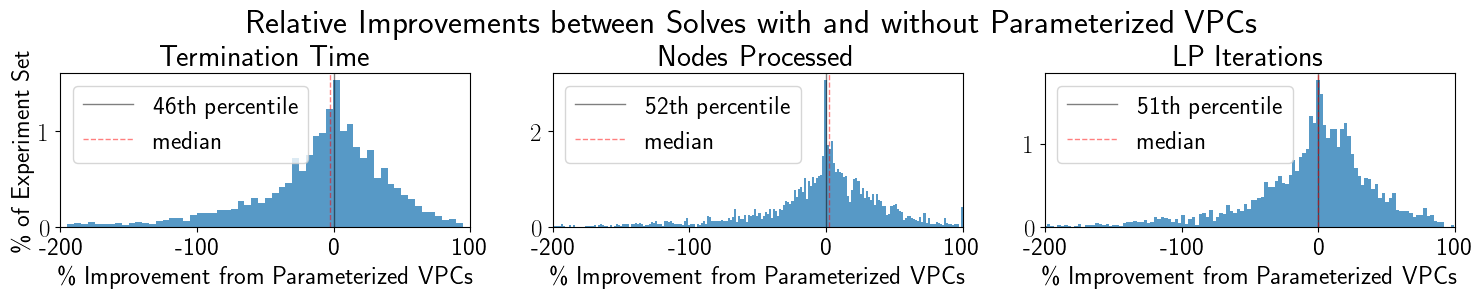

In [111]:
# Create a 3 x 1 figure with a size of 18 inches wide by 4 inches tall
plt.rc('text', usetex=True)
plt.rcParams['font.size'] = 18
fig = plt.figure(figsize=(18, 2))

# Create the first subplot (1 row, 3 columns, 1st plot)
ax1 = fig.add_subplot(1, 3, 1)
# Create a histogram with 600 bins
ax1.hist((gap_df["terminationTime None"] - gap_df["terminationTime Farkas"])/gap_df["terminationTime None"],
         bins=3000, density=True, alpha=0.75)
ax1.set_xlim(-2, 1)

cut_off = ((gap_df["terminationTime None"] - gap_df["terminationTime Farkas"])/gap_df["terminationTime None"]).quantile(.5)
zeroth_percentile = int(100 * round((gap_df["terminationTime None"] >= gap_df["terminationTime Farkas"]).sum() / len(gap_df), 2))
ax1.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5, label=f"{zeroth_percentile}th percentile")
ax1.axvline(cut_off, color='red', linestyle='--', linewidth=1, alpha=.5, label=f"median")

# Add labels and a title
ax1.set_xlabel('\% Improvement from Parameterized VPCs')
ax1.xaxis.set_major_formatter(formatter)  # Apply the custom formatter
ax1.set_ylabel('\% of Experiment Set')
ax1.set_title('Termination Time')
ax1.legend(loc="upper left")

# Create the second subplot (1 row, 3 columns, 3rd plot)
ax2 = fig.add_subplot(1, 3, 2)
# Create a histogram with 600 bins
ax2.hist((gap_df["nodes None"] - gap_df["nodes Farkas"])/gap_df["nodes None"],
         bins=10000, density=True, alpha=0.75)
ax2.set_xlim(-2, 1)

cut_off = ((gap_df["nodes None"] - gap_df["nodes Farkas"])/gap_df["nodes None"]).quantile(.5)
zeroth_percentile = int(100 * round((gap_df["nodes None"] >= gap_df["nodes Farkas"]).sum() / len(gap_df), 2))
ax2.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5, label=f"{zeroth_percentile}th percentile")
ax2.axvline(cut_off+.02, color='red', linestyle='--', linewidth=1, alpha=.5, label=f"median")

# Add labels and a title
ax2.set_xlabel('\% Improvement from Parameterized VPCs')
ax2.xaxis.set_major_formatter(formatter)  # Apply the custom formatter
ax2.set_title('Nodes Processed')
ax2.legend(loc="upper left")

# Create the second subplot (1 row, 3 columns, 3rd plot)
ax3 = fig.add_subplot(1, 3, 3)
# Create a histogram with 600 bins
ax3.hist((gap_df["iterations None"] - gap_df["iterations Farkas"])/gap_df["iterations None"],
         bins=10000, density=True, alpha=0.75)
ax3.set_xlim(-2, 1)

cut_off = ((gap_df["iterations None"] - gap_df["iterations Farkas"])/gap_df["iterations None"]).quantile(.5)
zeroth_percentile = int(100 * round((gap_df["iterations None"] >= gap_df["iterations Farkas"]).sum() / len(gap_df), 2))
ax3.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5, label=f"{zeroth_percentile}th percentile")
ax3.axvline(cut_off, color='red', linestyle='--', linewidth=1, alpha=.5, label=f"median")

# Add labels and a title
ax3.set_xlabel('\% Improvement from Parameterized VPCs')
ax3.xaxis.set_major_formatter(formatter)  # Apply the custom formatter
ax3.set_title('LP Iterations')
ax3.legend(loc="upper left")

# Set the shared title for the entire figure
fig.suptitle('Relative Improvements between Solves with and without Parameterized VPCs',
             x=.51, y=1.2, fontsize=24)

# Show the plot
fig.savefig(os.path.join(out_fldr, "combined_improvement_distribution.png"), dpi=1200, bbox_inches='tight')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


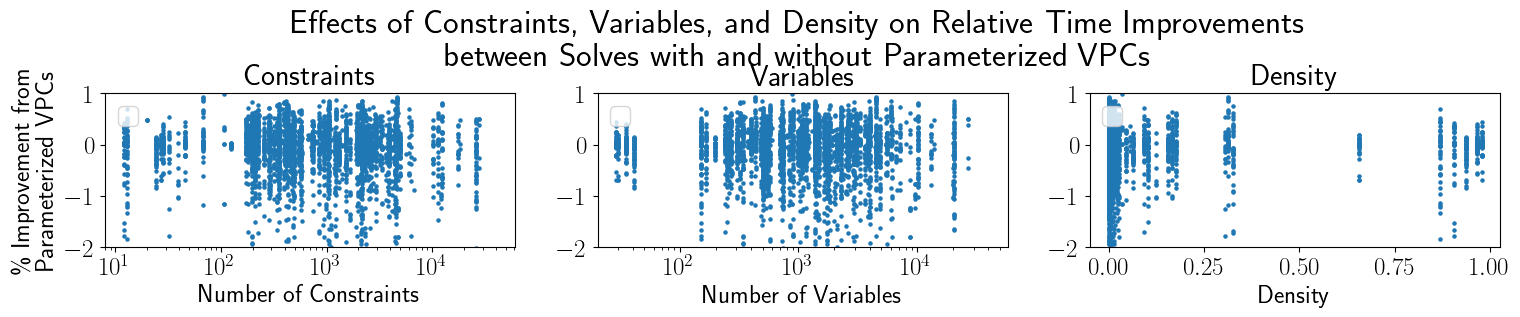

In [103]:
# Create a 3 x 1 figure with a size of 18 inches wide by 4 inches tall
plt.rc('text', usetex=True)
plt.rcParams['font.size'] = 18
fig = plt.figure(figsize=(18, 2))

# Create a scatter plot for rows vs relative time improvement
ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(gap_df["rows None"], (gap_df["terminationTime None"] - gap_df["terminationTime Farkas"])/gap_df["terminationTime None"], s=5)
ax1.set_xscale('log')
ax1.set_ylim(-2, 1)

# Add labels and a title
ax1.set_xlabel('Number of Constraints')
ax1.set_ylabel('\% Improvement from\nParameterized VPCs')
ax1.set_title('Constraints')
ax1.legend(loc="upper left")

# Create a scatter plot for cols vs relative time improvement
ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(gap_df["cols None"], (gap_df["terminationTime None"] - gap_df["terminationTime Farkas"])/gap_df["terminationTime None"], s=5)
ax2.set_xscale('log')
ax2.set_ylim(-2, 1)

# Add labels and a title
ax2.set_xlabel('Number of Variables')
ax2.set_title('Variables')
ax2.legend(loc="upper left")

# Create a scatter plot for density vs relative time improvement
ax3 = fig.add_subplot(1, 3, 3)
ax3.scatter(gap_df["density None"], (gap_df["terminationTime None"] - gap_df["terminationTime Farkas"])/gap_df["terminationTime None"], s=5)
ax3.set_ylim(-2, 1)

# Add labels and a title
ax3.set_xlabel('Density')
ax3.set_title('Density')
ax3.legend(loc="upper left")

# Set the shared title for the entire figure
fig.suptitle('Effects of Constraints, Variables, and Density on Relative Time Improvements\nbetween Solves with and without Parameterized VPCs',
             x=.51, y=1.3, fontsize=24)

# Show the plot
fig.savefig(os.path.join(out_fldr, "combined_improvement_distribution_by_size.png"), dpi=1200, bbox_inches='tight')
plt.show()

In [104]:
# read in meta data
features = pd.read_csv("miplib_2017_metadata.csv")

# format nicely
features.columns = [c.split()[0].lower() for c in features.columns]
tags = {t for tag_list in features["tags"] for t in tag_list.split(" ")}

# create density column
features["density"] = features["nonz."] / (features["variables"] * features["constraints"])

# encode tags as binary
for tag in tags:
    features[tag] = features["tags"].str.contains(tag)
    
# encode difficulty as binary
for difficulty in features["status"].unique():
    features[difficulty] = (features["status"] == difficulty)

# drop rows that lack finite objective
features['objective'] = pd.to_numeric(features['objective'], errors='coerce')
features = features.dropna(subset=['objective'])

# drop unnecessary columns    
features = features.drop(columns=["status", "submitter", "group", "tags", "objective"])

# set features index to instance
features = features.set_index("instance")

features.head()

,variables,binaries,integers,continuous,constraints,nonz.,density,cardinality,indicator,mixed_binary,...,decomposition,set_covering,set_packing,variable_bound,benchmark_suitable,equation_knapsack,infeasible,easy,hard,open
instance,,,,,,,,,,,,,,,,,,,,,
10teams,2025.0,1800.0,0.0,225,230,12150,0.026087,False,False,False,...,False,False,True,False,False,False,False,True,False,False
22433,429.0,231.0,0.0,198,198,3408,0.040121,False,False,True,...,False,False,False,False,False,False,False,True,False,False
23588,368.0,231.0,0.0,137,137,3701,0.073409,False,False,True,...,False,False,False,False,False,False,False,True,False,False
2club200v15p5scn,200.0,200.0,0.0,0,17013,104811,0.030803,False,False,False,...,False,False,False,True,False,False,False,False,True,False
30_70_45_05_100,10772.0,10771.0,0.0,1,12050,45889,0.000354,False,False,True,...,True,True,False,True,True,False,False,True,False,False


In [105]:
print([c for c in gap_df.columns if "Farkas" in c or not any(m in c for m in ["New", "None", "Old"])])

['instanceIndex', 'terms', 'instance', 'perturbation', 'degree', 'vpcGenerator Farkas', 'lpBound Farkas', 'disjunctiveDualBound Farkas', 'lpBoundPostVpc Farkas', 'rootDualBound Farkas', 'dualBound Farkas', 'primalBound Farkas', 'vpcGenerationTime Farkas', 'rootDualBoundTime Farkas', 'bestSolutionTime Farkas', 'terminationTime Farkas', 'nodes Farkas', 'iterations Farkas', 'maxTime Farkas', 'actualTerms Farkas', 'numCuts Farkas', 'cutLimit Farkas', 'mipSolver Farkas', 'providePrimalBound Farkas', 'infeasibleTerms Farkas', 'feasibleToInfeasibleTerms Farkas', 'infeasibleToFeasibleTerms Farkas', 'rows Farkas', 'cols Farkas', 'density Farkas', 'VPCs (Farkas)', 'Root Cuts (Farkas)', 'Root Optimality Gap Improvement', 'terminationTimeSansVpc Farkas', 'rootDualBoundTimeSansVpc Farkas', 'postRootTime Farkas', 'terminationTimeImprovement', 'nodeImprovement', 'iterationImprovement', 'terminationTimeRatio', 'nodeRatio', 'iterationRatio', 'infeasibleTermsRatio Farkas', 'infeasibleToFeasibleTermsRati

In [106]:
# create normalized columns for time improvement
gap_df["relative runtime improvement ratio"] = (gap_df["terminationTime None"] - gap_df["terminationTime Farkas"])/gap_df["terminationTime None"]
gap_df["relative runtime improvement"] = gap_df["relative runtime improvement ratio"] > 0

# create binary columns for perturbation
for p in gap_df["perturbation"].unique():
    gap_df[p] = (gap_df["perturbation"] == p)
    
# select our columns from gap_df
feature_cols = ["instance", "terms", "actualTerms Farkas", 'bound', 'objective', 'matrix', 'rhs', "degree", "numCuts Farkas", 'infeasibleTermsRatio Farkas',
                'infeasibleToFeasibleTermsRatio Farkas', 'zeroInfeasibleToFeasibleTerms Farkas', 'feasibleToInfeasibleTermsRatio Farkas',
                "Root Optimality Gap Improvement"]
label_cols = ["relative runtime improvement ratio", "relative runtime improvement"]
labels = gap_df[feature_cols + label_cols]

# drop rows where infeasibleToFeasibleTermsRatio Farkas or feasibleToInfeasibleTermsRatio Farkas is nonzero
# labels = labels.loc[(labels["infeasibleToFeasibleTermsRatio Farkas"] == 0) & (labels["feasibleToInfeasibleTermsRatio Farkas"] == 0)]

# format labels table
labels.set_index("instance", inplace=True)
labels.head()

/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_23454/411152561.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gap_df["relative runtime improvement ratio"] = (gap_df["terminationTime None"] - gap_df["terminationTime Farkas"])/gap_df["terminationTime None"]
/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_23454/411152561.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gap_df["relative runtime improvement"] = gap_df["relative runtime improvement ratio"] > 0
/var/folders/pb/p1sshd

,terms,actualTerms Farkas,bound,objective,matrix,rhs,degree,numCuts Farkas,infeasibleTermsRatio Farkas,infeasibleToFeasibleTermsRatio Farkas,zeroInfeasibleToFeasibleTerms Farkas,feasibleToInfeasibleTermsRatio Farkas,Root Optimality Gap Improvement,relative runtime improvement ratio,relative runtime improvement
instance,,,,,,,,,,,,,,,
aligninq,4,4,False,False,True,False,0.5,182,0.0,0.0,True,0.0,-0.005390,0.055888,True
aligninq,4,4,False,False,True,False,0.5,182,0.0,0.0,True,0.0,0.016590,0.361615,True
aligninq,4,4,False,False,True,False,0.5,182,0.0,0.0,True,0.0,0.000386,-1.112145,False
aligninq,4,4,False,False,True,False,0.5,182,0.0,0.0,True,0.0,-0.031147,-0.445568,False
n7-3,4,4,False,False,True,False,0.5,13,0.0,0.0,True,0.0,0.001611,-0.521342,False


In [107]:
# join features and labels
train = features.join(labels, how="inner")

In [108]:
# Identify numeric and non-numeric features
# numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
# non_numeric_features = X.select_dtypes(exclude=['float64', 'int64']).columns

# # Standardize numeric features (fit on training data, transform both train and test sets)
# scaler = StandardScaler()
# X_train_numeric_scaled = scaler.fit_transform(X_train[numeric_features])
# X_test_numeric_scaled = scaler.transform(X_test[numeric_features])
# 
# # Combine scaled numeric features with non-numeric features for both sets
# X_train_scaled = pd.DataFrame(X_train_numeric_scaled, columns=numeric_features, index=X_train.index)
# X_train_scaled[non_numeric_features] = X_train[non_numeric_features]
# 
# X_test_scaled = pd.DataFrame(X_test_numeric_scaled, columns=numeric_features, index=X_test.index)
# X_test_scaled[non_numeric_features] = X_test[non_numeric_features]

# Apply PCA on scaled numeric features only
# pca = PCA()
# X_train_pca = pca.fit_transform(X_train_numeric_scaled)
# X_test_pca = pca.transform(X_test_numeric_scaled)
# 
# # Create DataFrame for PCA components
# pca_train_df = pd.DataFrame(X_train_pca, columns=[f"PC{i+1}" for i in range(X_train_pca.shape[1])], index=X_train.index)
# pca_test_df = pd.DataFrame(X_test_pca, columns=[f"PC{i+1}" for i in range(X_test_pca.shape[1])], index=X_test.index)
# 
# # Add non-numeric features back to PCA dataframes (optional, depending on your modeling)
# pca_train_df[non_numeric_features] = X_train[non_numeric_features]
# pca_test_df[non_numeric_features] = X_test[non_numeric_features]
# 
# # Check explained variance ratio
# explained_variance = pca.explained_variance_ratio_
# print("Explained Variance Ratio for each component:", explained_variance)
# 
# # Plot cumulative explained variance
# plt.figure(figsize=(8, 5))
# plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o', linestyle='--')
# plt.xlabel('Number of Principal Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.title('Explained Variance vs Number of Components')
# plt.show()
# 
# # Select number of components to retain 95% variance
# n_components = (explained_variance.cumsum() <= 0.95).sum() + 1
# print(f"Number of components to retain 95% variance: {n_components}")
# 
# # Apply PCA again, reducing dimensionality
# pca_reducer = PCA(n_components=n_components)
# X_train_reduced = pca_reducer.fit_transform(X_train_numeric_scaled)
# X_test_reduced = pca_reducer.transform(X_test_numeric_scaled)
# 
# # Create reduced DataFrame for interpretability (optional)
# reduced_train_df = pd.DataFrame(X_train_reduced, columns=[f"PC{i+1}" for i in range(n_components)], index=X_train.index)
# reduced_test_df = pd.DataFrame(X_test_reduced, columns=[f"PC{i+1}" for i in range(n_components)], index=X_test.index)
# 
# # Add non-numeric features back if required
# reduced_train_df[non_numeric_features] = X_train[non_numeric_features]
# reduced_test_df[non_numeric_features] = X_test[non_numeric_features]
# 
# print(reduced_train_df.head())

In [109]:
# Separate features (X) and target variable (y)
X = train.drop(columns=label_cols)  # Drop the label columns to use the rest as features
y = train['relative runtime improvement ratio']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.0001, random_state=42)

# Initialize the linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_train)

# Evaluate the model
mae = mean_absolute_error(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

# Print evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

# Print model coefficients and intercept
print("Coefficients:")
d = dict(zip(X.columns, model.coef_))
d = sorted(d.items(), key=lambda x: abs(x[1]), reverse=True)  # make a list of key value pairs of d in descending order of coefficient
for col, coef in d:
    print(f"{col}: {coef}")

print("Intercept:", model.intercept_)

Mean Absolute Error (MAE): 0.892862691308736
Mean Squared Error (MSE): 13.160724358944018
R² Score: 0.050412802555935055
Coefficients:
Root Optimality Gap Improvement: 4.210741059273316
indicator: 2.138537671769895
numerics: -1.8151692586519768
equation_knapsack: 1.702314713168865
integer_knapsack: 1.4748109790817472
bound: -1.4388690296801594
mixed_binary: -1.2351647753744892
set_packing: -1.1954917418057658
cardinality: 0.7873413745398502
binary: 0.6682634944331235
objective: 0.572883748781303
decomposition: -0.5401460157207117
general_linear: -0.5371283752822195
matrix: 0.5106154439863769
binpacking: 0.4800598081003823
density: -0.4759282546003102
aggregations: 0.41708474052024114
precedence: -0.4093898896143211
infeasibleTermsRatio Farkas: 0.40188392019753005
knapsack: -0.3743683788236795
rhs: 0.35536983691248175
set_covering: -0.3136590714548554
variable_bound: 0.24845121819626909
hard: 0.1538573144922109
easy: -0.15385731449221057
benchmark: -0.08713551978087658
benchmark_suitabl

In [110]:
# Separate features (X) and target (y)
X = train.drop(columns=label_cols)  # Replace 'ratioPositive' with your binary target column
y = train['relative runtime improvement']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Logistic Regression model
model = LogisticRegression(penalty='l2', solver='liblinear')  # L2 regularization

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print model coefficients for each feature
print("\nFeature Effects (Coefficients):")
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)
print(coefficients)

Accuracy: 0.53

Confusion Matrix:
[[385   2]
 [334   1]]

Classification Report:
              precision    recall  f1-score   support

       False       0.54      0.99      0.70       387
        True       0.33      0.00      0.01       335

    accuracy                           0.53       722
   macro avg       0.43      0.50      0.35       722
weighted avg       0.44      0.53      0.38       722


Feature Effects (Coefficients):
                                  Feature  Coefficient
33                                  terms     0.001768
39                                 degree     0.000768
37                                 matrix     0.000656
15                                 binary     0.000617
9                            mixed_binary     0.000486
43   zeroInfeasibleToFeasibleTerms Farkas     0.000467
30                                   easy     0.000459
27                     benchmark_suitable     0.000306
13                              benchmark     0.000306
26       

## See Where My Work Went off the Rails

In [108]:
# create a table to compare unperturbed instances with aleks' results for them
groups = ["instance", "terms"]
fields = ["lpBound New", "disjunctiveDualBound New", "lpBoundPostVpc New", "rootDualBound None",
          "rootDualBound New", "primalBound None", "terminationTime None", "Root Cuts (New)", "Root Cuts (None)"]
comp = df.loc[df["instanceIndex"] == 0, groups + fields].groupby(groups).mean().reset_index()
comp.to_csv(os.path.join(out_fldr, "unperturbed_bound_table.csv"), index=False, mode="w")
comp

,instance,terms,lpBound New,disjunctiveDualBound New,lpBoundPostVpc New,rootDualBound None,rootDualBound New,primalBound None,terminationTime None,Root Cuts (New),Root Cuts (None)
0,10teams,4,9.170000e+02,9.170000e+02,9.170000e+02,9.240000e+02,9.240000e+02,924.0,1.095222,1.000000,1.000000
1,10teams,16,9.170000e+02,9.170000e+02,9.170000e+02,9.240000e+02,9.240000e+02,924.0,0.849162,1.000000,1.000000
2,10teams,64,9.170000e+02,9.170000e+02,9.170000e+02,9.240000e+02,9.240000e+02,924.0,0.955300,1.000000,1.000000
3,22433,4,2.124053e+04,2.131498e+04,2.131438e+04,2.139647e+04,2.141932e+04,21477.0,0.368808,0.756100,0.659438
4,23588,4,7.649866e+03,7.799913e+03,7.770875e+03,7.770368e+03,7.790990e+03,8090.0,1.673117,0.320639,0.273784
...,...,...,...,...,...,...,...,...,...,...,...
500,uct-subprob,4,2.420000e+02,2.426667e+02,2.426667e+02,2.777899e+02,2.777211e+02,314.0,3600.004986,0.496126,0.497083
501,uct-subprob,16,2.420000e+02,2.435588e+02,2.433241e+02,2.777899e+02,2.764205e+02,314.0,3600.004570,0.478063,0.497083
502,uct-subprob,64,2.420000e+02,2.440000e+02,2.434637e+02,2.777899e+02,2.761881e+02,314.0,3600.004331,0.474834,0.497083
503,umts,4,2.912957e+07,2.912989e+07,2.912987e+07,2.917164e+07,2.917680e+07,30090893.0,665.794987,0.049140,0.043769


In [109]:
# create a table with aleks's results for the unperturbed instances 
adf = pd.read_csv("aleks_results.csv")
adf = adf[["INSTANCE", "disj_terms", "LP OBJ", "BEST DISJ OBJ", "VPC OBJ", "AVG REF LAST_CUT_PASS", "AVG REF+V LAST_CUT_PASS", "ip_obj", "BEST REF TIME"]]
adf["rcnew"] = abs(adf["AVG REF+V LAST_CUT_PASS"] - adf["LP OBJ"]) / abs(adf["ip_obj"] - adf["LP OBJ"]) 
adf["rcnone"] = abs(adf["AVG REF LAST_CUT_PASS"] - adf["LP OBJ"]) / abs(adf["ip_obj"] - adf["LP OBJ"])
adf.columns = groups + fields
adf['instance'] = adf['instance'].str.replace('_presolved', '')
adf['instance'] = adf['instance'].str.replace('mas0', 'mas')
adf = adf.loc[(0 <= adf["Root Cuts (New)"]) & (adf["Root Cuts (New)"] <= 1)]

In [110]:
# join comp and adf on instance and terms to get a comparison of the two and see what's missing
keep_cols = groups + ["Root Cuts (New)", "Root Cuts (None)", "terminationTime None"]
both = comp[keep_cols].merge(adf[keep_cols], on=groups, suffixes=(" sean", " aleks"), how="outer")
both

,instance,terms,Root Cuts (New) sean,Root Cuts (None) sean,terminationTime None sean,Root Cuts (New) aleks,Root Cuts (None) aleks,terminationTime None aleks
0,10teams,4.0,1.000000,1.000000,1.095222,1.000000,1.000000,0.301
1,10teams,16.0,1.000000,1.000000,0.849162,1.000000,1.000000,0.302
2,10teams,64.0,1.000000,1.000000,0.955300,NaN,NaN,NaN
3,22433,4.0,0.756100,0.659438,0.368808,0.675821,0.667379,0.093
4,23588,4.0,0.320639,0.273784,1.673117,0.318880,0.243813,0.420
...,...,...,...,...,...,...,...,...
2115,umts,64.0,NaN,NaN,NaN,0.049433,0.047454,49.839
2116,usAbbrv-8-25_70,64.0,NaN,NaN,NaN,0.000000,0.000000,3600.000
2117,vpm1,64.0,NaN,NaN,NaN,0.721295,0.681575,0.004
2118,vpm2,64.0,NaN,NaN,NaN,0.719205,0.718862,0.098


In [111]:
# make a dataframe that compares the experiments we both ran
diff = both.loc[~pd.isna(both["Root Cuts (New) sean"]) & ~pd.isna(both["Root Cuts (New) aleks"])]
diff["improvement aleks"] = (diff["Root Cuts (New) aleks"] - diff["Root Cuts (None) aleks"]) / diff["Root Cuts (None) aleks"]

# get some summary stats - looks like we are pretty close
# I expect the difference is that I'm not adding GMICs and I'm using different sized disjunctions 
diff[diff.columns[2:]].mean()

/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_1960/3402183073.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff["improvement aleks"] = (diff["Root Cuts (New) aleks"] - diff["Root Cuts (None) aleks"]) / diff["Root Cuts (None) aleks"]


Root Cuts (New) sean            0.560396
Root Cuts (None) sean           0.553168
terminationTime None sean     625.631718
Root Cuts (New) aleks           0.541650
Root Cuts (None) aleks          0.521054
terminationTime None aleks    310.003514
improvement aleks                    inf
dtype: float64

In [112]:
# let's examine the instances for which I don't have data
mdf = both.loc[(both["Root Cuts (None) sean"].isna()) & (both["terms"].isin([4, 16, 64])),
               ["instance", "terms", "Root Cuts (New) aleks", "Root Cuts (None) aleks", "terminationTime None aleks"]]
mdf.columns = ["instance", "terms", "Root Cuts (New)", "Root Cuts (None)", "terminationTime None"]
mdf["improvement"] = (mdf["Root Cuts (New)"] - mdf["Root Cuts (None)"]) / mdf["Root Cuts (None)"]
mdf

,instance,terms,Root Cuts (New),Root Cuts (None),terminationTime None,improvement
88,decomp1,64.0,NaN,NaN,NaN,NaN
330,neos-555424,16.0,NaN,NaN,NaN,NaN
331,neos-555424,64.0,NaN,NaN,NaN,NaN
463,shipschedule3shipsi,4.0,NaN,NaN,NaN,NaN
464,shipschedule3shipsi,16.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2115,umts,64.0,0.049433,0.047454,49.839,0.041720
2116,usAbbrv-8-25_70,64.0,0.000000,0.000000,3600.000,NaN
2117,vpm1,64.0,0.721295,0.681575,0.004,0.058276
2118,vpm2,64.0,0.719205,0.718862,0.098,0.000477


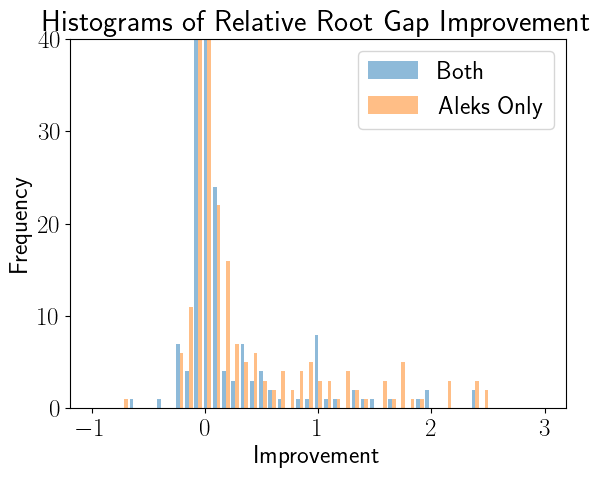

In [113]:
# Plot histograms
plt.hist([diff["improvement aleks"], mdf["improvement"]], bins=np.linspace(-1, 3, 50), alpha=0.5, label=['Both', 'Aleks Only'])

plt.ylim(0, 40)

# Add labels and title
plt.xlabel('Improvement')
plt.ylabel('Frequency')
plt.title('Histograms of Relative Root Gap Improvement')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [114]:
# set the index of mdf to the combination of instance and terms
mdf = mdf.set_index(["instance", "terms"])
mdf

Root Cuts (New)  Root Cuts (None)  \
instance            terms                                      
decomp1             64.0               NaN               NaN   
neos-555424         16.0               NaN               NaN   
                    64.0               NaN               NaN   
shipschedule3shipsi 4.0                NaN               NaN   
                    16.0               NaN               NaN   
...                                    ...               ...   
umts                64.0          0.049433          0.047454   
usAbbrv-8-25_70     64.0          0.000000          0.000000   
vpm1                64.0          0.721295          0.681575   
vpm2                64.0          0.719205          0.718862   
zib54-UUE           64.0          0.681297          0.687208   

                           terminationTime None  improvement  
instance            terms                                     
decomp1             64.0                    NaN          NaN  
neos-555424         16.0                    NaN          NaN  
                    64.0                    NaN          NaN  
shipschedule3shipsi 4.0                     NaN          NaN  
                    16.0                    NaN          NaN  
...                                         ...          ...  
umts                64.0                 49.839     0.041720  
usAbbrv-8-25_70     64.0               3600.000          NaN  
vpm1                64.0                  0.004     0.058276  
vpm2                64.0                  0.098     0.000477  
zib54-UUE           64.0                103.298    -0.008602  

[591 rows x 4 columns]

In [115]:
# classify missing experiment data by excluded instance (either aleks' mislabeled or I just missed), max run time, unperturbable, or run time error
mdf["reason"] = "unknown"

# read in list of dropped instances from aleks' data set
# i think the issue is some aleks tested despite saying he wasn't and others were more than 5k x 5k rows but preprocess to less
dropped = pd.read_csv("dropped.csv", index_col="instance")

for (instance, terms) in mdf.index:
    cur_inst_test_set_fldr = os.path.join(test_set_fldr, instance)
    if instance + ".mps" not in os.listdir(instance_fldr):
        if instance in dropped.index:
            mdf.loc[(instance, terms), "reason"] = "dropped"  # excluded by vpc
        else:
            mdf.loc[(instance, terms), "reason"] = "missed"  # not run yet
    elif mdf.loc[(instance, terms), "terminationTime None"] > 3599:
        mdf.loc[(instance, terms), "reason"] = "max run time"  # hit the max run time
    elif not os.path.exists(cur_inst_test_set_fldr) or not os.listdir(cur_inst_test_set_fldr):
        mdf.loc[(instance, terms), "reason"] = "unperturbable"  # weren't able to perturb
    else:
        mdf.loc[(instance, terms), "reason"] = "runtime error"  # crashed or ran within 1 hour but no results data

In [116]:
# summary stats on where our improving runs are hiding
stats = mdf.groupby("reason").agg({'Root Cuts (New)': 'mean', 'Root Cuts (None)': 'mean', 'improvement': 'count'}).reset_index()
stats.rename(columns={"improvement": "count"}, inplace=True)
stats["weighted improvement"] = (stats["Root Cuts (New)"] - stats["Root Cuts (None)"]) * stats["count"]
stats["weighted improvement"] = (stats["weighted improvement"] / stats["weighted improvement"].sum()).round(4)
stats.sort_values("weighted improvement", ascending=False)

,reason,Root Cuts (New),Root Cuts (None),count,weighted improvement
2,missed,0.498358,0.450770,300,0.6221
0,dropped,0.738627,0.621918,48,0.2441
3,runtime error,0.319636,0.281815,77,0.1269
1,max run time,0.269524,0.267290,55,0.0054
4,unperturbable,0.523079,0.521500,23,0.0016


In [117]:
# track down the experiments we excluded because we missed creating them
# stein9 is an outlier pushing things up
missing = mdf[mdf["reason"] == "missed"]
missing

,,Root Cuts (New),Root Cuts (None),terminationTime None,improvement,reason
instance,terms,,,,,
bc,4.0,0.302212,0.302552,35.878,-0.001122,missed
bc1,4.0,0.427863,0.448678,6.347,-0.046393,missed
bell3a,4.0,0.478648,0.478648,0.214,0.000000,missed
bell3b,4.0,0.901596,0.491740,0.121,0.833481,missed
bell5,4.0,0.284498,0.294200,0.038,-0.032977,missed
...,...,...,...,...,...,...
stein45_nocard,64.0,0.590909,0.263384,3.653,1.243528,missed
tanglegram2,64.0,1.000000,0.980850,0.047,0.019524,missed
timtab2,64.0,0.480566,0.476907,3600.000,0.007673,missed


In [118]:
# let's look at what aleks "missed"
aleks_missing = both.loc[pd.isna(both["Root Cuts (New) aleks"])].drop_duplicates("instance").sort_values("instance")
aleks_missing["row"], aleks_missing["col"], aleks_missing["source"] = 0, 0, "unknown"
aleks_missing.set_index("instance", inplace=True)

# get problem size
for instance in aleks_missing.index:
    aleks_missing.loc[instance, "row"] = rows.get(instance, 0)
    aleks_missing.loc[instance, "col"] = cols.get(instance, 0)
    
# get source of instance
for instance in aleks_missing.index:
    for fldr in os.listdir("../../"):
        if not os.path.isdir(f"../../{fldr}"):
            continue
        if instance + ".mps" in os.listdir(f"../../{fldr}") or instance + ".mps.gz" in os.listdir(f"../../{fldr}"):
            aleks_missing.loc[instance, "source"] = fldr

# trim down to what we want - looks like mas misnamed but otherwise we are good
aleks_missing = aleks_missing[["row", "col", "source"]]
aleks_missing

,row,col,source
instance,,,
10teams,230,2025,miplib3
app2-2,335,1226,miplib2017
app3,766,3080,miplib2017
arki001,1048,1388,miplib3
beavma,372,390,miplib2017
bppc8-02,59,232,miplib2017
ci-s4,26159,745,miplib2017
decomp1,8357,10735,miplib2017
f2gap401600,40,1600,miplib2017


In [119]:
# now lets track down which error modes are sinking us most
run_error = mdf[mdf["reason"] == "runtime error"]

# collect the ways each instance/term combination fails
err_map = []

# iterate over instances and terms of aleks' tests we're missing because of run errors
for instance, terms in run_error.index:
    terms = int(terms)
    found_err = False
    
    # iterate over our error modes to find matches
    for mode, failed_experiments in err.items():
        for failed_experiment in failed_experiments:
            if f"{instance}_" in failed_experiment and f"_{terms}_" in failed_experiment:
                
                # if we find a match, see if we can get a more specific error mode
                sub_mode = mode
                if sub_mode == "no vpcs were made from a new disjunction":
                    sub_mode = [vpc_err_mode for vpc_err_mode, vpc_err_exps in vpc_err.items()
                            if failed_experiment in vpc_err_exps].pop()
                
                # append the mode
                err_map.append({
                    "instance": instance,
                    "terms": float(terms),
                    "mode": sub_mode,
                    "experiment": failed_experiment,
                    "experiment group": "_".join(failed_experiment.split("_")[:-1]),
                    "cut type": failed_experiment.split("_")[-1]
                })
                found_err = True
                
    # do the same thing as the above for all other termination modes
    misc = {"other": other, "warning": warning, "empty": empty}
    for mode, failed_experiments in misc.items():
        for failed_experiment in failed_experiments:
            if f"{instance}_" in failed_experiment and f"_{terms}_" in failed_experiment:
                err_map.append({
                    "instance": instance,
                    "terms": float(terms),
                    "mode": mode,
                    "experiment": failed_experiment,
                    "experiment group": "_".join(failed_experiment.split("_")[:-1]),
                    "cut type": failed_experiment.split("_")[-1]
                })
                found_err = True
                
    # double check to make sure we didn't miss any of aleks' runs for another reason
    if not found_err:
        print("no code for", instance, terms)
        
# add the error mode to the dataframe
run_error = pd.merge(run_error, pd.DataFrame(err_map).set_index(["instance", "terms"]), left_index=True, right_index=True)

# now drop the runs that showed up as failures only because their siblings failed
empty = run_error[(run_error["mode"] == "empty")]
non_empty = run_error[run_error["mode"] != "empty"]
collateral = pd.merge(empty, non_empty[["experiment group", "experiment"]],
                      on="experiment group", how="left", suffixes=("", " collateral"))
false_negs = collateral.loc[~collateral["experiment collateral"].isna(), "experiment"].unique()
run_error = run_error[~run_error["experiment"].isin(false_negs)]

run_error

no code for a2c1s1 4
no code for neos5 4
no code for a2c1s1 16
no code for neos5 16
no code for a2c1s1 64
no code for neos5 64


Root Cuts (New)  Root Cuts (None)  terminationTime None  \
instance terms                                                            
22433    16.0          0.911359          0.667379                 0.078   
         16.0          0.911359          0.667379                 0.078   
         16.0          0.911359          0.667379                 0.078   
         16.0          0.911359          0.667379                 0.078   
         16.0          0.911359          0.667379                 0.078   
...                         ...               ...                   ...   
umts     64.0          0.049433          0.047454                49.839   
         64.0          0.049433          0.047454                49.839   
         64.0          0.049433          0.047454                49.839   
         64.0          0.049433          0.047454                49.839   
         64.0          0.049433          0.047454                49.839   

                improvement         reason  \
instance terms                               
22433    16.0      0.365579  runtime error   
         16.0      0.365579  runtime error   
         16.0      0.365579  runtime error   
         16.0      0.365579  runtime error   
         16.0      0.365579  runtime error   
...                     ...            ...   
umts     64.0      0.041720  runtime error   
         64.0      0.041720  runtime error   
         64.0      0.041720  runtime error   
         64.0      0.041720  runtime error   
         64.0      0.041720  runtime error   

                                                             mode  \
instance terms                                                      
22433    16.0   CglVPC: Finishing with exit reason: OPTIMAL_SO...   
         16.0   CglVPC: Finishing with exit reason: OPTIMAL_SO...   
         16.0   CglVPC: Finishing with exit reason: OPTIMAL_SO...   
         16.0   CglVPC: Finishing with exit reason: OPTIMAL_SO...   
         16.0   CglVPC: Finishing with exit reason: OPTIMAL_SO...   
...                                                           ...   
umts     64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   

                                 experiment      experiment group cut type  
instance terms                                                              
22433    16.0      22433_objective_1_16_New  22433_objective_1_16      New  
         16.0      22433_objective_1_16_Old  22433_objective_1_16      Old  
         16.0   22433_objective_1_16_Farkas  22433_objective_1_16   Farkas  
         16.0         22433_matrix_1_16_New     22433_matrix_1_16      New  
         16.0         22433_matrix_1_16_Old     22433_matrix_1_16      Old  
...                                     ...                   ...      ...  
umts     64.0      umts_objective_-1_64_Old  umts_objective_-1_64      Old  
         64.0   umts_objective_-1_64_Farkas  umts_objective_-1_64   Farkas  
         64.0           umts_bound_1_64_New       umts_bound_1_64      New  
         64.0           umts_bound_1_64_Old       umts_bound_1_64      Old  
         64.0        umts_bound_1_64_Farkas       umts_bound_1_64   Farkas  

[1671 rows x 9 columns]

In [120]:
# summary stats on where improvements are by failure mode
run_error_stats = run_error.groupby("mode").agg({'Root Cuts (New)': 'mean', 'Root Cuts (None)': 'mean', 'improvement': 'count'}).reset_index()
run_error_stats.rename(columns={"improvement": "count"}, inplace=True)
run_error_stats["weighted improvement"] = (run_error_stats["Root Cuts (New)"] - run_error_stats["Root Cuts (None)"]) * run_error_stats["count"]
run_error_stats["weighted improvement"] = (run_error_stats["weighted improvement"] / run_error_stats["weighted improvement"].sum()).round(4)
run_error_stats.sort_values("weighted improvement", ascending=False)

,mode,Root Cuts (New),Root Cuts (None),count,weighted improvement
3,CglVPC: Finishing with exit reason: OPTIMAL_SO...,0.509986,0.311466,162,0.6497
7,bad_alloc,0.434958,0.277109,71,0.2264
5,CglVPC: Finishing with exit reason: PRLP_TIME_...,0.361451,0.344290,360,0.1248
2,CglVPC: Finishing with exit reason: NO_DISJUNC...,0.309472,0.302437,93,0.0132
0,CglVPC: Finishing with exit reason: FAIL_LIMIT,0.844483,0.843900,18,0.0002
6,CglVPC: Finishing with exit reason: TIME_LIMIT,0.394754,0.394694,63,0.0001
8,dot product with obj differs from solver,0.771781,0.773766,1,-0.0000
9,must have primalbound >= root lp objective,0.441229,0.444428,9,-0.0006
1,CglVPC: Finishing with exit reason: NO_CUTS_LI...,0.071182,0.071550,108,-0.0008
10,warning,0.431084,0.434163,20,-0.0012


In [121]:
# todo: find out range of terms for time outs (are most because big tree?)
prlp_limit = run_error[run_error["mode"] == "CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT"]
prlp_limit

Root Cuts (New)  Root Cuts (None)  terminationTime None  \
instance terms                                                            
30n20b8  4.0           0.163007          0.169100                10.769   
         4.0           0.163007          0.169100                10.769   
         4.0           0.163007          0.169100                10.769   
         4.0           0.163007          0.169100                10.769   
         4.0           0.163007          0.169100                10.769   
...                         ...               ...                   ...   
umts     64.0          0.049433          0.047454                49.839   
         64.0          0.049433          0.047454                49.839   
         64.0          0.049433          0.047454                49.839   
         64.0          0.049433          0.047454                49.839   
         64.0          0.049433          0.047454                49.839   

                improvement         reason  \
instance terms                               
30n20b8  4.0      -0.036033  runtime error   
         4.0      -0.036033  runtime error   
         4.0      -0.036033  runtime error   
         4.0      -0.036033  runtime error   
         4.0      -0.036033  runtime error   
...                     ...            ...   
umts     64.0      0.041720  runtime error   
         64.0      0.041720  runtime error   
         64.0      0.041720  runtime error   
         64.0      0.041720  runtime error   
         64.0      0.041720  runtime error   

                                                             mode  \
instance terms                                                      
30n20b8  4.0    CglVPC: Finishing with exit reason: PRLP_TIME_...   
         4.0    CglVPC: Finishing with exit reason: PRLP_TIME_...   
         4.0    CglVPC: Finishing with exit reason: PRLP_TIME_...   
         4.0    CglVPC: Finishing with exit reason: PRLP_TIME_...   
         4.0    CglVPC: Finishing with exit reason: PRLP_TIME_...   
...                                                           ...   
umts     64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   

                                  experiment       experiment group cut type  
instance terms                                                                
30n20b8  4.0       30n20b8_objective_1_4_New  30n20b8_objective_1_4      New  
         4.0       30n20b8_objective_1_4_Old  30n20b8_objective_1_4      Old  
         4.0    30n20b8_objective_1_4_Farkas  30n20b8_objective_1_4   Farkas  
         4.0            30n20b8_rhs_-1_4_New       30n20b8_rhs_-1_4      New  
         4.0            30n20b8_rhs_-1_4_Old       30n20b8_rhs_-1_4      Old  
...                                      ...                    ...      ...  
umts     64.0       umts_objective_-1_64_Old   umts_objective_-1_64      Old  
         64.0    umts_objective_-1_64_Farkas   umts_objective_-1_64   Farkas  
         64.0            umts_bound_1_64_New        umts_bound_1_64      New  
         64.0            umts_bound_1_64_Old        umts_bound_1_64      Old  
         64.0         umts_bound_1_64_Farkas        umts_bound_1_64   Farkas  

[432 rows x 9 columns]

In [122]:
# figure out actual disjunction sizes in experiments
# a regex that matches "solving for term \d+/\d+" and captures the second number
term_regex = re.compile(r"Solving for term \d+/(\d+)")

# compare timed out PRLPs to non-timed out PRLPs
actual_terms = {}
provided_terms = {}
missed_terms = []
aleks_terms = {}

# iterate over all expected runs
for instance in os.listdir(test_set_fldr):
    if not os.path.isdir(os.path.join(test_set_fldr, instance)):
        continue
    for perturbation in os.listdir(os.path.join(test_set_fldr, instance)):
        if not os.path.isdir(os.path.join(test_set_fldr, instance, perturbation)):
            continue
        p, d = perturbation.split("_")
        if int(d) not in degrees:
            continue
        for terms in term_list:
            for generator in ["None", "New", "Old", "Farkas"]:
                
                val = df.loc[(df["instance"] == instance) & (df["perturbation"] == perturbation.split("_")[0]) &
                             (df["terms"] == terms) & (df["instanceIndex"] == 0), "actualTerms New"].mean()

                # get the out file for this experiment
                stem = f"{instance}_{perturbation}_{terms}_{generator}"
                provided_terms[stem] = terms
                out_file_pth = os.path.join(results_fldr, f"{stem}.out")
                if not os.path.exists(out_file_pth):
                    continue

                # read the out file
                with open(out_file_pth, "r") as f:
                    text = f.read()
                
                # search for the regex in the text
                matches = term_regex.findall(text)
                
                if matches:
                    actual_terms[stem] = int(matches[-1])
                    if generator == "Farkas":
                        aleks_terms[instance, terms] = aleks_terms.get((instance, terms), []) + [int(matches[-1])]
                else:
                    missed_terms.append(stem)
                    
# get average sized disjunction for aleks' runs
aleks_terms = {k: {"actual terms": np.mean(v)} for k, v in aleks_terms.items()}
                    
len(missed_terms) / len(provided_terms)

0.2856330553449583

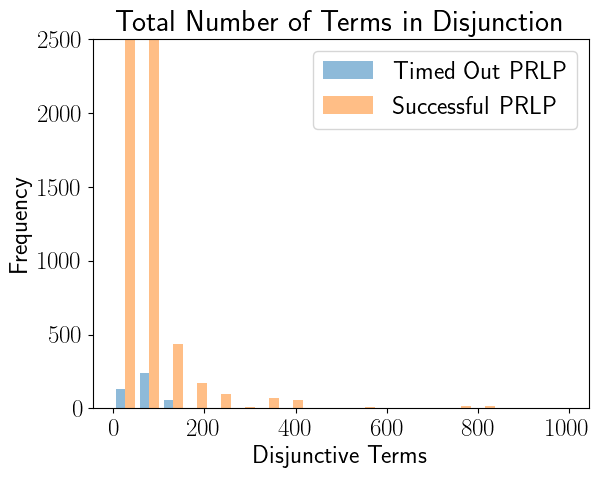

In [123]:
# plot whether or not number of disjunctive terms has an effect on timing out
actual_term_failures = [terms for stem, terms in actual_terms.items()
                        if stem in prlp_limit["experiment"].values]
actual_term_success = [terms for stem, terms in actual_terms.items()
                       if stem not in prlp_limit["experiment"].values]

deciles = {
    "success": {i * 10: np.percentile(actual_term_success, i * 10) for i in range(1, 10)},
    "failure": {i * 10: np.percentile(actual_term_failures, i * 10) for i in range(1, 10)}
}

# Plot histograms
plt.hist([actual_term_failures, actual_term_success], bins=np.linspace(0, 1000, 20), alpha=0.5, label=['Timed Out PRLP', 'Successful PRLP'])

# Add labels and title
plt.xlabel('Disjunctive Terms')
plt.ylabel('Frequency')
plt.title(f'Total Number of Terms in Disjunction')

# set y limit
plt.ylim(0, 2500)

# Add legend
plt.legend()

# Show the plot
plt.show()

In [124]:
# get deciles on number of rows or disjunctive terms for failed and successful PRLP solves
pd.DataFrame(deciles)

,success,failure
10,4.0,4.0
20,4.0,16.0
30,4.0,28.0
40,16.0,64.0
50,19.0,64.0
60,45.0,66.0
70,64.0,73.0
80,66.0,89.0
90,95.0,125.0


In [125]:
# what do improvements look like in terms of disjunctive terms
adf

,instance,terms,lpBound New,disjunctiveDualBound New,lpBoundPostVpc New,rootDualBound None,rootDualBound New,primalBound None,terminationTime None,Root Cuts (New),Root Cuts (None)
0,22433,2.0,2.124053e+04,21314.98074,2.131206e+04,2.141369e+04,2.140756e+04,21500.0,0.078,0.643722,0.667379
1,23588,2.0,7.649866e+03,7746.197749,7.726713e+03,7.757177e+03,7.789200e+03,8090.0,0.419,0.316571,0.243813
2,10teams,2.0,9.170000e+02,917,9.170000e+02,9.240000e+02,9.240000e+02,924.0,0.303,1.000000,1.000000
3,30n20b8,2.0,1.241230e+02,124.2095421,1.241823e+02,1.542021e+02,1.528972e+02,302.0,13.008,0.161765,0.169100
4,50v-10,2.0,2.879066e+03,2884.065687,2.884066e+03,3.195241e+03,3.199688e+03,3310.0,1928.063,0.744017,0.733697
...,...,...,...,...,...,...,...,...,...,...,...
2635,umts,64.0,2.912957e+07,29131573.54,2.913061e+07,2.917562e+07,2.917754e+07,30100000.0,49.839,0.049433,0.047454
2636,usAbbrv-8-25_70,64.0,9.500000e+01,95,9.500000e+01,9.500000e+01,9.500000e+01,120.0,3600.000,0.000000,0.000000
2637,vpm1,64.0,1.643333e+01,16.71111111,1.660000e+01,1.886429e+01,1.900595e+01,20.0,0.004,0.721295,0.681575
2638,vpm2,64.0,1.113563e+01,11.5093094,1.134045e+01,1.305095e+01,1.305186e+01,13.8,0.098,0.719205,0.718862


In [126]:
# augment aleks' results with actual disjunctive terms
atdf = pd.DataFrame.from_dict(aleks_terms, orient="index").reset_index()
atdf.columns = ["instance", "terms", "actual terms"]
atdf = pd.merge(adf, atdf, on=["instance", "terms"])
atdf = atdf[atdf["terms"] == 64]
atdf["term group"] = "None"
atdf.set_index("instance", inplace=True)
for instance in atdf.index:
    atdf.loc[instance, "term group"] = "64" if atdf.loc[instance, "actual terms"] == 64 else \
        "65 - 69" if 65 <= atdf.loc[instance, "actual terms"] <= 69 else \
        "70 - 79" if 70 <= atdf.loc[instance, "actual terms"] <= 79 else \
        "80 - 89" if 80 <= atdf.loc[instance, "actual terms"] <= 89 else \
        "90 - 99" if 90 <= atdf.loc[instance, "actual terms"] <= 99 else \
        "100 - 199" if 100 <= atdf.loc[instance, "actual terms"] <= 199 else \
        "200 - 299" if 200 <= atdf.loc[instance, "actual terms"] <= 299 else \
        "300 - 399" if 300 <= atdf.loc[instance, "actual terms"] <= 399 else \
        "400 - 499" if 400 <= atdf.loc[instance, "actual terms"] <= 499 else \
        "500 - 749" if 500 <= atdf.loc[instance, "actual terms"] <= 749 else \
        "750 - 999" if 750 <= atdf.loc[instance, "actual terms"] <= 999 else "1000+"
atdf

,terms,lpBound New,disjunctiveDualBound New,lpBoundPostVpc New,rootDualBound None,rootDualBound New,primalBound None,terminationTime None,Root Cuts (New),Root Cuts (None),actual terms,term group
instance,,,,,,,,,,,,
23588,64.0,7.649866e+03,7967.565214,7.965067e+03,7.757177e+03,7.965776e+03,8090.0,0.421,0.717759,0.243813,66.0,65 - 69
30n20b8,64.0,1.241230e+02,126.9060983,NaN,0.000000e+00,0.000000e+00,302.0,0.000,0.697802,0.697802,151.0,100 - 199
50v-10,64.0,2.879066e+03,2956.881654,2.927394e+03,3.195241e+03,3.200751e+03,3310.0,1770.796,0.746484,0.733697,64.0,64
a1c1s1,64.0,4.649668e+03,4985.201862,NaN,0.000000e+00,0.000000e+00,11500.0,0.000,0.678751,0.678751,64.0,64
aflow30a,64.0,9.831674e+02,1013.177723,1.012586e+03,1.096636e+03,1.095069e+03,1160.0,2.305,0.632812,0.641674,102.0,100 - 199
...,...,...,...,...,...,...,...,...,...,...,...,...
tr12-30,64.0,2.530221e+04,27137.94988,2.580549e+04,1.290671e+05,1.292165e+05,131000.0,69.269,0.983126,0.981713,64.0,64
traininstance2,64.0,0.000000e+00,0,NaN,0.000000e+00,0.000000e+00,71800.0,0.000,0.000000,0.000000,70.0,70 - 79
traininstance6,64.0,0.000000e+00,0,NaN,0.000000e+00,0.000000e+00,28300.0,0.000,0.000000,0.000000,95.0,90 - 99


In [127]:
# summary stats on where improvements are by disjunction size for 64 term runs
actual_term_stats = atdf.groupby("term group").agg({'Root Cuts (New)': 'mean', 'Root Cuts (None)': 'mean', 'actual terms': 'count'}).reset_index()
actual_term_stats.rename(columns={"actual terms": "count"}, inplace=True)
actual_term_stats["weighted improvement"] = (actual_term_stats["Root Cuts (New)"] - actual_term_stats["Root Cuts (None)"]) * actual_term_stats["count"]
actual_term_stats["weighted improvement"] = (actual_term_stats["weighted improvement"] / actual_term_stats["weighted improvement"].sum()).round(4)
actual_term_stats.sort_values("weighted improvement", ascending=False)

,term group,Root Cuts (New),Root Cuts (None),count,weighted improvement
3,64,0.541543,0.520073,82,0.3365
4,65 - 69,0.509274,0.469424,32,0.2437
1,200 - 299,0.494808,0.308327,4,0.1426
6,80 - 89,0.359922,0.317667,11,0.0888
2,300 - 399,0.493920,0.279814,2,0.0818
5,70 - 79,0.396822,0.363190,12,0.0771
0,100 - 199,0.553443,0.545504,19,0.0288
7,90 - 99,0.302498,0.301863,4,0.0005


In [1]:
# break down size outs by number of terms